In [24]:
! apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [25]:
!git clone https://github.com/ebtezcan/EV-Charger-Prediction.git

fatal: destination path 'EV-Charger-Prediction' already exists and is not an empty directory.


# Leading the Charge: Predicting the Demand for Electric Vehicles and Chargers in Washington State

## TABLE OF CONTENTS

*Click to jump to matching Markdown Header.*<br><br>

- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# INTRODUCTION

## Market at a Glance
Climate change, including concerns about rising greenhouse gas emissions, has become an increasingly pressing concern among officials in the United States and around the world over the past several years. According to the U.S. Environmental Protection Agency (EPA), "greenhouse gas (GHG) emissions from transportation account for about 29 percent of total U.S. greenhouse gas emissions, making it the largest contributor of U.S. GHG emissions."[¹](https://www.epa.gov/transportation-air-pollution-and-climate-change/carbon-pollution-transportation) In light of these findings and the research being conducted around this issue, President Joe Biden and his administration are working on passing a [bipartisan infrastructure deal](https://www.whitehouse.gov/briefing-room/statements-releases/2021/06/24/fact-sheet-president-biden-announces-support-for-the-bipartisan-infrastructure-framework/) that would prioritize clean energy and support the development of a nationwide network of electric vehicle chargers.

In addition to large scale policy proposals at the national level, some states are also taking action on their own. For example, both California and Washington are working towards mandating electric vehicles by 2035 and 2030 respectively in an effort to phase out vehicles that use gasoline. Furthermore, within the private sector, several major car manufacturers (such as Ford, GM, Volvo, etc.) have [announced](https://www.caranddriver.com/news/g35562831/ev-plans-automakers-timeline/) that they will be going fully electric in the next decade, which would prove to be a significant change in the auto industry. Taken together, if implemented, these changes in both the public and private sectors would cause a massive increase in demand for electric vehicles (EVs). The question is: how will the current charging infrastructure of these states support an influx in demand for new EVs?

## Business Case
To be able to achieve a fully electric future and keep up with the demand for chargers, the charging infrastructure has to be expanded. Therefore, the Washington Department of Transportation is planning to spend $8 million on charging infrastructure projects between July 1st, 2021 and June 30, 2023[²](https://wsdot.wa.gov/business/innovative-partnerships/zero-emission-vehicle-infrastructure-partnerships). This is a great business opportunity for EV charging companies. By investing in Washington state, not only would these companies be eligible for government funding, but they would also put themselves in a profitable position as the demand for chargers continues to increase over the coming years.

## Business Problem & Goal
In order to position electric vehicle chargers strategically, it is vital to model and predict the demand for electric vehicles in each county in Washington. In an effort to find counties that will have the most demand with the least amount of chargers, this analysis focuses on time series modeling of the amount of electric vehicles in the top 10 counties within Washington with the most purchases of new electric vehicles. Our goal is to recommend top 3 counties to invest in.

# OBTAIN

For our analysis we will be using the [electric vehicle title and registration activity data](https://data.wa.gov/Transportation/Electric-Vehicle-Title-and-Registration-Activity/rpr4-cgyd) provided by Washington state to calculate the amount of electric vehicles in each county over time. Additionally, in the Interpret section we will be looking at the [current charging infrastructure data](https://developer.nrel.gov/docs/transportation/alt-fuel-stations-v1/all/) provided by the National Renewable Energy Laboratory to find counties with the most potential for generating financial success.

## Obtaining data from Washington State

### Accessing and Storing API Keys

In [26]:
#option to run API calls in the notebook
run_api_calls = False

In [27]:
if run_api_calls == True:
    #defining a function to open/load json files
    import json

    def get_keys(path):
        """Function accesses and returns the json file at the specified path.
        -------------------------------
        Arguments:
        path : str, the file path belonging to the json file to be opened and
        returned.
        """
        with open(path) as f:
            return json.load(f)

In [28]:
#storing api keys in variables
if run_api_calls == True:
    keys = get_keys("/Users/berke/.secret/socrata_api_project_5.json")

    api_key_socrata = keys['api_key']
    app_token_socrata = keys['app_token']
    api_key_secret_socrata = keys['api_key_secret']

### API Requests and Pagination

In [29]:
import requests
import time
import pandas as pd

if run_api_calls == True:
    #Defining/initializing API request headers and parameters
    headers = {'X-App-Token': app_token_socrata, 'username': api_key_socrata,
               'password': api_key_secret_socrata}
    params = {'$limit': '50000', '$offset': None}
    offset = list(range(0, 500000, 50000))

    #Requesting data from API and parsing results to a dictionary
    dfs = {}
    for number in offset:
        params['$offset'] = str(number)
        r = requests.get(f'https://data.wa.gov/resource/rpr4-cgyd.json?',
                         headers=headers, params=params)
        dfs[f'df_{number}']=pd.DataFrame.from_records(r.json())
        time.sleep(1)

### Parsing results to a final compressed .csv file

In [30]:
if run_api_calls == True:
    #saving all pages as one csv file
    import os
    from datetime import date

    today = date.today().strftime("%m-%d-%Y")
    path = './data'
    output_file = os.path.join(path,f'title_transactions-{today}.csv.gz')

    for key, df in dfs.items():
        if key == 'df_0':
            df_final = dfs['df_0']
        else:
            df_final = pd.concat([df_final, df], axis=0)

    df_final.to_csv(output_file, index=False, compression='gzip')

### Importing data

In [31]:
#importing the data back into the notebook
df=pd.read_csv('/content/EV-Charger-Prediction/data/title_transactions-06-29-2021.csv.gz', compression='gzip', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 433172 entries, 0 to 433171
Data columns (total 30 columns):
 #   Column                                                   Non-Null Count   Dtype  
---  ------                                                   --------------   -----  
 0   electric_vehicle_type                                    433172 non-null  object 
 1   vin_1_10                                                 433172 non-null  object 
 2   model_year                                               433172 non-null  int64  
 3   make                                                     433172 non-null  object 
 4   model                                                    433172 non-null  object 
 5   new_or_used_vehicle                                      433172 non-null  object 
 6   sale_price                                               433172 non-null  float64
 7   transaction_date                                         433172 non-null  object 
 8   transaction_type   

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# SCRUB

## Feature Engineering

### Changing type of 'transaction_date' to datetime

Since we will be using the transaction_date column for the time series we are going to be creating, we need to change its type from object to datetime.

In [33]:
#display all columns
pd.set_option('max_columns', None)
df.head()

OptionError: Pattern matched multiple keys

In [34]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df.head()

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_date,transaction_type,transaction_year,...,dol_vehicle_id,legislative_district,hb_2042_clean_alternative_fuel_vehicle_cafv_eligibility,meets_2019_hb_2042_electric_range_requirement,meets_2019_hb_2042_sale_date_requirement,meets_2019_hb_2042_sale_price_value_requirement,odometer_reading,odometer_code,transportation_electrification_fee_paid,hybrid_vehicle_electrification_fee_paid
0,Battery Electric Vehicle (BEV),5YJXCBE2XG,2016,TESLA,Model X,New,102000.0,2017-01-31,Original Title,2017,...,348693390,48.0,TRANSACTION NOT ELIGIBLE: Sale before August 2...,True,False,False,50,Actual Mileage,Not Applicable,Not Applicable
1,Battery Electric Vehicle (BEV),5YJXCBE49H,2017,TESLA,Model X,New,0.0,2017-03-22,Original Registration,2017,...,329748177,5.0,"TRANSACTION NOT ELIGIBLE: Non-sale, registrati...",True,False,False,0,Odometer reading is not collected at time of r...,No,No
2,Battery Electric Vehicle (BEV),5YJXCBE49H,2017,TESLA,Model X,New,166250.0,2017-03-22,Original Title,2017,...,329748177,5.0,TRANSACTION NOT ELIGIBLE: Sale before August 2...,True,False,False,50,Actual Mileage,Not Applicable,Not Applicable
3,Plug-in Hybrid Electric Vehicle (PHEV),1G1RA6S59H,2017,CHEVROLET,Volt,New,0.0,2017-03-24,Original Registration,2017,...,242531271,10.0,"TRANSACTION NOT ELIGIBLE: Non-sale, registrati...",True,False,False,0,Odometer reading is not collected at time of r...,No,No
4,Plug-in Hybrid Electric Vehicle (PHEV),1G1RA6S59H,2017,CHEVROLET,Volt,New,32499.0,2017-03-24,Original Title,2017,...,242531271,10.0,TRANSACTION NOT ELIGIBLE: Sale before August 2019,True,False,True,99,Actual Mileage,Not Applicable,Not Applicable


### Feature Engineering "m/y" column

We will be using the m/y information to clean duplicates in section 4.5.

In [35]:
df['m/y'] = df['transaction_date'].dt.strftime("%m-%Y")

### Adjusting the index of df

In [36]:
df.set_index('transaction_date', inplace=True)
df.head()

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,transaction_year,electric_vehicle_fee_paid,...,legislative_district,hb_2042_clean_alternative_fuel_vehicle_cafv_eligibility,meets_2019_hb_2042_electric_range_requirement,meets_2019_hb_2042_sale_date_requirement,meets_2019_hb_2042_sale_price_value_requirement,odometer_reading,odometer_code,transportation_electrification_fee_paid,hybrid_vehicle_electrification_fee_paid,m/y
transaction_date,,,,,,,,,,,,,,,,,,,,,
2017-01-31,Battery Electric Vehicle (BEV),5YJXCBE2XG,2016,TESLA,Model X,New,102000.0,Original Title,2017,Not Applicable,...,48.0,TRANSACTION NOT ELIGIBLE: Sale before August 2...,True,False,False,50,Actual Mileage,Not Applicable,Not Applicable,01-2017
2017-03-22,Battery Electric Vehicle (BEV),5YJXCBE49H,2017,TESLA,Model X,New,0.0,Original Registration,2017,No,...,5.0,"TRANSACTION NOT ELIGIBLE: Non-sale, registrati...",True,False,False,0,Odometer reading is not collected at time of r...,No,No,03-2017
2017-03-22,Battery Electric Vehicle (BEV),5YJXCBE49H,2017,TESLA,Model X,New,166250.0,Original Title,2017,Not Applicable,...,5.0,TRANSACTION NOT ELIGIBLE: Sale before August 2...,True,False,False,50,Actual Mileage,Not Applicable,Not Applicable,03-2017
2017-03-24,Plug-in Hybrid Electric Vehicle (PHEV),1G1RA6S59H,2017,CHEVROLET,Volt,New,0.0,Original Registration,2017,No,...,10.0,"TRANSACTION NOT ELIGIBLE: Non-sale, registrati...",True,False,False,0,Odometer reading is not collected at time of r...,No,No,03-2017
2017-03-24,Plug-in Hybrid Electric Vehicle (PHEV),1G1RA6S59H,2017,CHEVROLET,Volt,New,32499.0,Original Title,2017,Not Applicable,...,10.0,TRANSACTION NOT ELIGIBLE: Sale before August 2019,True,False,True,99,Actual Mileage,Not Applicable,Not Applicable,03-2017


## Column Exploration

There is great information in this dataframe but there seems to also be irrelevant information for our purposes. In order to clean up the dataframe we need to know which columns we should keep and which ones we should drop.

### Dropping columns that are for Governmental Use

To start off, there are several columns that seem to be of use for the government or the vehicle's owner but is irrelevant for us in answering the business question at hand. Some examples include the following along with the description provided in the API:

**'meets_2019_hb_2042_electric_range_requirement':** True = The vehicle model can travel 30 miles or more solely on electricity. Otherwise, False.

**'meets_2019_hb_2042_sale_date_requirement':** True = The vehicle was sold on or after August 1, 2019. Otherwise, False.

**'meets_2019_hb_2042_sale_price_value_requirement':** True = The vehicle sale price/value was 45,000 or less for new vehicles, or 30,000 or less for used vehicles. Otherwise, False.

**'hb_2042_clean_alternative_fuel_vehicle_cafv_eligibility':** Shows if vehicle title transactions were eligible for the sales tax exemption authorized by House Bill 2042 during the 2019 Legislative Session. If not eligible, reasons are provided.

**'non_clean_alternative_fuel':** Shows if new vehicle title transactions were eligible for the sales tax exemption authorized by House Bill 2778 during the 2015 Legislative Session. If not eligible, reasons are provided.

**'transportation_electrification_fee_paid':** The Transportation Electrification Fee is charged to some electric vehicles when they renew their registration. This indicates if it was collected during the transaction

**'hybrid_vehicle_electrification_fee_paid':** The Hybrid Vehicle Electrification Fee is charged to some electric vehicles when they renew their registration. This indicates if it was collected during the transaction.

**'legislative_district':** The specific section of Washington State that the vehicle's owner resides in, as represented in the state legislature.

**'electric_vehicle_fee_paid':** The Electric Vehicle Fee is charged to some electric vehicles when they renew their registration. This indicates if it was collected during the transaction.

We can go ahead and drop these columns since these are mostly about whether a fee was paid or if the vehicle met certain governmental requirements for tax credits or otherwise.

In [37]:
drop_cols = ['electric_vehicle_fee_paid',
             'hb_2042_clean_alternative_fuel_vehicle_cafv_eligibility',
             'meets_2019_hb_2042_electric_range_requirement',
             'meets_2019_hb_2042_sale_date_requirement',
             'meets_2019_hb_2042_sale_price_value_requirement',
             'transportation_electrification_fee_paid',
             'hybrid_vehicle_electrification_fee_paid', 'legislative_district',
             'non_clean_alternative_fuel']
df.drop(drop_cols, axis=1, inplace=True)
df.head()

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,transaction_year,county,...,zip,electric_range,base_msrp,date_of_vehicle_sale,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,,,,
2017-01-31,Battery Electric Vehicle (BEV),5YJXCBE2XG,2016,TESLA,Model X,New,102000.0,Original Title,2017,King,...,98039.0,200,0,2016-12-27T00:00:00.000,Passenger,WA,348693390,50,Actual Mileage,01-2017
2017-03-22,Battery Electric Vehicle (BEV),5YJXCBE49H,2017,TESLA,Model X,New,0.0,Original Registration,2017,King,...,98065.0,200,0,NaN,Passenger,WA,329748177,0,Odometer reading is not collected at time of r...,03-2017
2017-03-22,Battery Electric Vehicle (BEV),5YJXCBE49H,2017,TESLA,Model X,New,166250.0,Original Title,2017,King,...,98065.0,200,0,2017-03-03T00:00:00.000,Passenger,WA,329748177,50,Actual Mileage,03-2017
2017-03-24,Plug-in Hybrid Electric Vehicle (PHEV),1G1RA6S59H,2017,CHEVROLET,Volt,New,0.0,Original Registration,2017,Island,...,98277.0,53,0,NaN,Passenger,WA,242531271,0,Odometer reading is not collected at time of r...,03-2017
2017-03-24,Plug-in Hybrid Electric Vehicle (PHEV),1G1RA6S59H,2017,CHEVROLET,Volt,New,32499.0,Original Title,2017,Island,...,98277.0,53,0,2017-03-11T00:00:00.000,Passenger,WA,242531271,99,Actual Mileage,03-2017


### Dropping columns with redundant information

In [38]:
df['date_of_vehicle_sale'].isna().sum()

289770

Since we have the full transaction date in our index the 'transaction_year' column is redundant. Additionally, the date_of_vehicle_sale column seems to be missing quite a bit of information. Where there is data, the difference between the transaction date and the actual vehicle sale seems to be around a couple weeks so the difference is not meaningful for our purposes.

Also, we already have the sale price of the vehicle at the time of the transaction so the base MSRP column is irrelevant. So we can go ahead and drop these columns from our dataframe as well. We will be keeping the rest of the columns for the time being for EDA purposes.

In [39]:
drop_cols = ['transaction_year', 'base_msrp', 'date_of_vehicle_sale']
df.drop(drop_cols, axis=1, inplace=True)
df.head()

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2017-01-31,Battery Electric Vehicle (BEV),5YJXCBE2XG,2016,TESLA,Model X,New,102000.0,Original Title,King,MEDINA,98039.0,200,Passenger,WA,348693390,50,Actual Mileage,01-2017
2017-03-22,Battery Electric Vehicle (BEV),5YJXCBE49H,2017,TESLA,Model X,New,0.0,Original Registration,King,SNOQUALMIE,98065.0,200,Passenger,WA,329748177,0,Odometer reading is not collected at time of r...,03-2017
2017-03-22,Battery Electric Vehicle (BEV),5YJXCBE49H,2017,TESLA,Model X,New,166250.0,Original Title,King,SNOQUALMIE,98065.0,200,Passenger,WA,329748177,50,Actual Mileage,03-2017
2017-03-24,Plug-in Hybrid Electric Vehicle (PHEV),1G1RA6S59H,2017,CHEVROLET,Volt,New,0.0,Original Registration,Island,OAK HARBOR,98277.0,53,Passenger,WA,242531271,0,Odometer reading is not collected at time of r...,03-2017
2017-03-24,Plug-in Hybrid Electric Vehicle (PHEV),1G1RA6S59H,2017,CHEVROLET,Volt,New,32499.0,Original Title,Island,OAK HARBOR,98277.0,53,Passenger,WA,242531271,99,Actual Mileage,03-2017


We will not be using the registration information for this analysis and instead will be focusing on the title transactions to calculate the amount of electric vehicles on the road. Therefore we can filter out this information from our dataframe.

In [40]:
#filtering out registration information to keep vehicle purchase information
df=df[(df['transaction_type']=='Original Title') |
      (df['transaction_type']=='Transfer Title')]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121542 entries, 2017-01-31 to 2017-05-01
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   electric_vehicle_type  121542 non-null  object 
 1   vin_1_10               121542 non-null  object 
 2   model_year             121542 non-null  int64  
 3   make                   121542 non-null  object 
 4   model                  121542 non-null  object 
 5   new_or_used_vehicle    121542 non-null  object 
 6   sale_price             121542 non-null  float64
 7   transaction_type       121542 non-null  object 
 8   county                 121534 non-null  object 
 9   city                   121514 non-null  object 
 10  zip                    121537 non-null  float64
 11  electric_range         121542 non-null  int64  
 12  vehicle_primary_use    121542 non-null  object 
 13  state_of_residence     121540 non-null  object 
 14  dol_vehicle_id      

## Addressing Duplicates

Now that we have a dataframe that shows only the purchases of new and used cars and none of the registration information, we can go ahead and address duplicates.

### Exact Duplicates

In [41]:
df[df.duplicated()]

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2018-04-24,Plug-in Hybrid Electric Vehicle (PHEV),1G1RB6S51J,2018,CHEVROLET,Volt,New,33108.0,Original Title,Snohomish,EDMONDS,98020.0,53,Passenger,WA,165661520,5,Actual Mileage,04-2018
2017-03-15,Plug-in Hybrid Electric Vehicle (PHEV),1FADP5CU6E,2014,FORD,C-max,Used,15000.0,Original Title,Grant,EPHRATA,98823.0,19,Passenger,WA,154225991,18388,Actual Mileage,03-2017
2019-01-02,Battery Electric Vehicle (BEV),5YJXCBE27J,2018,TESLA,Model X,New,114700.0,Original Title,King,SEATTLE,98102.0,238,Passenger,WA,116650978,50,Actual Mileage,01-2019
2019-04-05,Battery Electric Vehicle (BEV),5YJ3E1EA9K,2019,TESLA,Model 3,New,46200.0,Original Title,King,SEATTLE,98102.0,220,Passenger,WA,209719674,50,Actual Mileage,04-2019
2018-07-13,Battery Electric Vehicle (BEV),5YJ3E1EA5J,2018,TESLA,Model 3,New,57500.0,Original Title,Clark,CAMAS,98607.0,215,Passenger,WA,338187300,50,Actual Mileage,07-2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-17,Battery Electric Vehicle (BEV),1N4AZ0CP5F,2015,NISSAN,Leaf,Used,9950.0,Original Title,King,KENMORE,98028.0,84,Passenger,WA,117975602,30068,Actual Mileage,01-2017
2017-01-13,Plug-in Hybrid Electric Vehicle (PHEV),1G1RB6E49D,2013,CHEVROLET,Volt,Used,0.0,Original Title,Kittitas,ELLENSBURG,98926.0,38,Passenger,WA,349914309,30899,Actual Mileage,01-2017
2017-03-08,Plug-in Hybrid Electric Vehicle (PHEV),1G1RA6E42D,2013,CHEVROLET,Volt,Used,13992.0,Transfer Title,Pierce,GRAHAM,98338.0,38,Passenger,WA,136639037,25903,Actual Mileage,03-2017


> We have 1287 rows of data that are duplicated. In order to make sure that these are indeed duplicates with no differences we will inspect a few of the vehicles below:

#### Inspecting Duplicates

In [42]:
df[df['dol_vehicle_id']==165661520]

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2018-04-24,Plug-in Hybrid Electric Vehicle (PHEV),1G1RB6S51J,2018,CHEVROLET,Volt,New,33108.0,Original Title,Snohomish,EDMONDS,98020.0,53,Passenger,WA,165661520,5,Actual Mileage,04-2018
2018-04-24,Plug-in Hybrid Electric Vehicle (PHEV),1G1RB6S51J,2018,CHEVROLET,Volt,New,33108.0,Original Title,Snohomish,EDMONDS,98020.0,53,Passenger,WA,165661520,5,Actual Mileage,04-2018


In [43]:
df[df['dol_vehicle_id']==154225991]

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2017-03-15,Plug-in Hybrid Electric Vehicle (PHEV),1FADP5CU6E,2014,FORD,C-max,Used,15000.0,Original Title,Grant,EPHRATA,98823.0,19,Passenger,WA,154225991,18388,Actual Mileage,03-2017
2017-03-15,Plug-in Hybrid Electric Vehicle (PHEV),1FADP5CU6E,2014,FORD,C-max,Used,15000.0,Original Title,Grant,EPHRATA,98823.0,19,Passenger,WA,154225991,18388,Actual Mileage,03-2017


Data in each column for these transactions seem to be exactly the same so we can go ahead and drop these rows.

In [44]:
df.drop_duplicates(inplace=True)
#verifying that duplicates have been removed
len(df[df.duplicated()])

0

In [45]:
df[df['dol_vehicle_id']==154225991]

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2017-03-15,Plug-in Hybrid Electric Vehicle (PHEV),1FADP5CU6E,2014,FORD,C-max,Used,15000.0,Original Title,Grant,EPHRATA,98823.0,19,Passenger,WA,154225991,18388,Actual Mileage,03-2017


### Duplicates by Date/ID/County

In [46]:
df[df.duplicated(subset=['m/y', 'dol_vehicle_id', 'county'], keep=False)].sort_values('dol_vehicle_id')

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2018-12-10,Plug-in Hybrid Electric Vehicle (PHEV),WBY1Z4C57G,2016,BMW,i3,Used,19967.0,Transfer Title,King,RENTON,98057.0,72,Passenger,WA,46112,19433,Actual Mileage,12-2018
2018-12-10,Plug-in Hybrid Electric Vehicle (PHEV),WBY1Z4C57G,2016,BMW,i3,Used,19967.0,Transfer Title,King,KIRKLAND,98033.0,72,Passenger,WA,46112,19433,Actual Mileage,12-2018
2019-06-19,Battery Electric Vehicle (BEV),KNDJP3AEXG,2016,KIA,SOUL,Used,11000.0,Transfer Title,Benton,KENNEWICK,99336.0,93,Passenger,WA,110708,26166,Actual Mileage,06-2019
2019-06-19,Battery Electric Vehicle (BEV),KNDJP3AEXG,2016,KIA,SOUL,Used,11000.0,Transfer Title,Benton,RICHLAND,99352.0,93,Passenger,WA,110708,26166,Actual Mileage,06-2019
2019-09-26,Plug-in Hybrid Electric Vehicle (PHEV),1G1RC6S54H,2017,CHEVROLET,Volt,Used,18276.0,Transfer Title,Clark,VANCOUVER,98685.0,53,Passenger,WA,1069358,35710,Actual Mileage,09-2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-09,Battery Electric Vehicle (BEV),5YJ3E1EB1K,2019,TESLA,Model 3,New,55190.0,Original Title,King,SEATTLE,98109.0,220,Passenger,WA,478846056,50,Actual Mileage,10-2019
2019-11-01,Battery Electric Vehicle (BEV),5YJ3E1EA4K,2019,TESLA,Model 3,Used,39100.0,Original Title,Pierce,SPANAWAY,98387.0,220,Passenger,WA,478854330,375,Actual Mileage,11-2019
2019-11-01,Battery Electric Vehicle (BEV),5YJ3E1EA4K,2019,TESLA,Model 3,Used,39100.0,Original Title,Pierce,TACOMA,98405.0,220,Passenger,WA,478854330,375,Actual Mileage,11-2019


The dataframe currently contains 7241 rows of duplicated data. In this case, there are duplications for the same cars since there is different city and zipcode information shown in the transactions. Otherwise the data is exactly the same. We will be keeping the last of each of the duplicated rows.

In [47]:
df.drop_duplicates(subset=['m/y', 'dol_vehicle_id', 'county'], keep='last',
                   inplace=True)

In [48]:
df.head()

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2017-01-31,Battery Electric Vehicle (BEV),5YJXCBE2XG,2016,TESLA,Model X,New,102000.0,Original Title,King,MEDINA,98039.0,200,Passenger,WA,348693390,50,Actual Mileage,01-2017
2017-03-22,Battery Electric Vehicle (BEV),5YJXCBE49H,2017,TESLA,Model X,New,166250.0,Original Title,King,SNOQUALMIE,98065.0,200,Passenger,WA,329748177,50,Actual Mileage,03-2017
2017-03-24,Plug-in Hybrid Electric Vehicle (PHEV),1G1RA6S59H,2017,CHEVROLET,Volt,New,32499.0,Original Title,Island,OAK HARBOR,98277.0,53,Passenger,WA,242531271,99,Actual Mileage,03-2017
2017-02-15,Battery Electric Vehicle (BEV),KNDCB3LCXH,2017,KIA,Niro,New,22890.0,Original Title,King,KENT,98042.0,0,Passenger,WA,200890098,5,Actual Mileage,02-2017
2016-12-30,Battery Electric Vehicle (BEV),1N4BZ0CP2G,2016,NISSAN,Leaf,New,32500.0,Original Title,Snohomish,MILL CREEK,98012.0,84,Passenger,WA,117062585,16,Actual Mileage,12-2016


### Duplicates by Date/ID

In [49]:
df[df.duplicated(subset=['m/y', 'dol_vehicle_id'],
                 keep=False)].sort_values('dol_vehicle_id')

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2017-05-12,Plug-in Hybrid Electric Vehicle (PHEV),KNAGV4LDXH,2017,KIA,Optima,New,36395.0,Original Title,Walla Walla,WALLA WALLA,99362.0,29,Passenger,WA,1061763,20,Actual Mileage,05-2017
2017-05-12,Plug-in Hybrid Electric Vehicle (PHEV),KNAGV4LDXH,2017,KIA,Optima,New,36395.0,Original Title,Yakima,YAKIMA,98901.0,29,Passenger,WA,1061763,20,Actual Mileage,05-2017
2018-03-30,Plug-in Hybrid Electric Vehicle (PHEV),5UXKT0C59G,2016,BMW,X5,Used,38977.0,Transfer Title,King,BELLEVUE,98004.0,14,Passenger,WA,1121270,42505,Actual Mileage,03-2018
2018-03-30,Plug-in Hybrid Electric Vehicle (PHEV),5UXKT0C59G,2016,BMW,X5,Used,38977.0,Transfer Title,Whatcom,BLAINE,98230.0,14,Passenger,WA,1121270,42505,Actual Mileage,03-2018
2018-12-07,Battery Electric Vehicle (BEV),1N4AZ0CPXF,2015,NISSAN,Leaf,Used,11991.0,Transfer Title,King,BELLEVUE,98008.0,84,Passenger,WA,1155164,28482,Actual Mileage,12-2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-15,Battery Electric Vehicle (BEV),5YJ3E1EB4K,2019,TESLA,Model 3,New,56190.0,Original Title,Thurston,LACEY,98516.0,220,Passenger,WA,478598431,50,Actual Mileage,10-2019
2019-10-05,Battery Electric Vehicle (BEV),5YJ3E1EB5K,2019,TESLA,Model 3,New,56190.0,Original Title,Adams,OTHELLO,99344.0,220,Passenger,WA,478679400,50,Actual Mileage,10-2019
2019-10-05,Battery Electric Vehicle (BEV),5YJ3E1EB5K,2019,TESLA,Model 3,New,56190.0,Original Title,Benton,RICHLAND,99352.0,220,Passenger,WA,478679400,50,Actual Mileage,10-2019


Similar to the duplicates we removed in the prior section, we have duplicate transactions showing up for the same cars with exactly the same information except for the county, city and zipcode information. We will once again assume that the last transaction for each of these duplications is the accurate one, and keep it.

In [50]:
df.drop_duplicates(subset=['m/y', 'dol_vehicle_id'], keep='last', inplace=True)

In [51]:
df[df.duplicated(subset=['m/y', 'dol_vehicle_id'], keep=False)].sort_values('dol_vehicle_id')

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114458 entries, 2017-01-31 to 2017-05-01
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   electric_vehicle_type  114458 non-null  object 
 1   vin_1_10               114458 non-null  object 
 2   model_year             114458 non-null  int64  
 3   make                   114458 non-null  object 
 4   model                  114458 non-null  object 
 5   new_or_used_vehicle    114458 non-null  object 
 6   sale_price             114458 non-null  float64
 7   transaction_type       114458 non-null  object 
 8   county                 114452 non-null  object 
 9   city                   114431 non-null  object 
 10  zip                    114453 non-null  float64
 11  electric_range         114458 non-null  int64  
 12  vehicle_primary_use    114458 non-null  object 
 13  state_of_residence     114456 non-null  object 
 14  dol_vehicle_id      

## Checking for and Addressing Null Values

Next, we will be checking for and addressing null values in the dataset.

In [53]:
df.isna().sum()

,0
electric_vehicle_type,0
vin_1_10,0
model_year,0
make,0
model,0
new_or_used_vehicle,0
sale_price,0
transaction_type,0
county,6
city,27


Here, we see that 4 columns: 'county', 'city', 'zip' and 'state_of_residence' all have null values. We can check the display the null values in each column to see if we can fill them in.

In [54]:
df[df['county'].isna()]

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2019-04-16,Battery Electric Vehicle (BEV),5YJXCDE46J,2018,TESLA,Model X,New,105000.0,Original Title,NaN,ALISO VIEJO,92656.0,238,Passenger,CA,229979662,1195,Actual Mileage,04-2019
2019-12-26,Plug-in Hybrid Electric Vehicle (PHEV),KMHC65LD3K,2019,HYUNDAI,Ioniq,New,24684.0,Original Title,NaN,MC GUIRE AFB,8641.0,29,Passenger,NJ,8189709,9,Actual Mileage,12-2019
2021-03-19,Plug-in Hybrid Electric Vehicle (PHEV),3FA6P0PUXG,2016,FORD,Fusion,Used,0.0,Original Title,NaN,FPO,96620.0,19,Passenger,CA,148972407,52000,Actual Mileage,03-2021
2014-09-23,Battery Electric Vehicle (BEV),JN1AZ0CP1B,2011,NISSAN,Leaf,Used,0.0,Transfer Title,NaN,NaN,NaN,73,Passenger,NaN,133789183,46005,Actual Mileage,09-2014
2017-12-18,Battery Electric Vehicle (BEV),5YJSA1S14E,2014,TESLA,MODEL S,Used,0.0,Transfer Title,NaN,WESTMONT,60559.0,208,Passenger,IL,145245145,39620,Actual Mileage,12-2017
2018-02-28,Plug-in Hybrid Electric Vehicle (PHEV),5UXKT0C38H,2017,BMW,X5,Used,55000.0,Transfer Title,NaN,NaN,NaN,14,Passenger,NaN,111058636,6919,Actual Mileage,02-2018


The county information is missing on vehicles with owners residing in different states. Our analysis is focused on the Washington State and without in-state address information these data points are not going to be useful so we can go ahead and drop these from our dataframe.

In [55]:
#dropping null values
df.dropna(subset=['county'], inplace=True)

In [56]:
#verifying that the null values have been dropped
df[df['county'].isna()]

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,


As discussed above, the data analysis is focused on Washington State, hence there is no reason to keep vehicles with owners residing outside of WA since we don't have their in-state locations. Additionally, this will remove all null values from the state_of_residence column.

In [57]:
df=df[df['state_of_residence']=='WA']

In [58]:
df[df['city'].isna()]

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2013-09-10,Battery Electric Vehicle (BEV),1N4AZ0CPXD,2013,NISSAN,Leaf,New,0.00,Original Title,Whatcom,NaN,98266.0,75,Passenger,WA,162570523,16,Actual Mileage,09-2013
2017-02-21,Battery Electric Vehicle (BEV),1N4BZ0CP4G,2016,NISSAN,Leaf,New,30200.00,Original Title,San Juan,NaN,98280.0,84,Passenger,WA,119455920,100,Actual Mileage,02-2017
2017-04-05,Battery Electric Vehicle (BEV),5YJXCAE23H,2017,TESLA,Model X,New,122000.00,Original Title,San Juan,NaN,98243.0,200,Passenger,WA,266866526,50,Actual Mileage,04-2017
2019-12-16,Battery Electric Vehicle (BEV),1N4BZ1CP0K,2019,NISSAN,Leaf,New,41800.00,Original Title,San Juan,NaN,98280.0,150,Passenger,WA,3653366,210,Actual Mileage,12-2019
2017-07-12,Battery Electric Vehicle (BEV),JN1AZ0CPXC,2012,NISSAN,Leaf,Used,7000.00,Transfer Title,San Juan,NaN,98243.0,73,Passenger,WA,208715517,35077,Actual Mileage,07-2017
2020-09-22,Battery Electric Vehicle (BEV),1G1FY6S09L,2020,CHEVROLET,Bolt EV,New,30204.24,Original Title,Skagit,NaN,98221.0,259,Exempt (State/County/Local/Tribal),WA,124578051,4,Actual Mileage,09-2020
2021-03-31,Plug-in Hybrid Electric Vehicle (PHEV),WBY1Z4C55E,2014,BMW,i3,Used,12300.00,Original Title,San Juan,NaN,98243.0,72,Passenger,WA,148276376,58562,Actual Mileage,03-2021
2017-12-04,Battery Electric Vehicle (BEV),1N4BZ0CP7H,2017,NISSAN,Leaf,New,38351.00,Original Title,San Juan,NaN,98280.0,107,Passenger,WA,208825039,28,Actual Mileage,12-2017
2020-09-22,Battery Electric Vehicle (BEV),1G1FY6S00L,2020,CHEVROLET,Bolt EV,New,30204.24,Original Title,Skagit,NaN,98221.0,259,Exempt (State/County/Local/Tribal),WA,124526531,4,Actual Mileage,09-2020


Since we are mainly concerned about the vehicles on a county level the null values in the city column are not concerning; however, we can change the null values with 'Unknown' as a placeholder.

In [59]:
#filling null values
df['city'].fillna('Unknown', inplace=True)
#verifying that null values have been replaced
df[df['city'].isna()]

<ipython-input-59-919421b0ffe8>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['city'].fillna('Unknown', inplace=True)


,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,


In [60]:
df[df['zip'].isna()]

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2019-05-17,Battery Electric Vehicle (BEV),KL8CL6S03G,2016,CHEVROLET,Spark,Used,9991.0,Original Title,Whitman,PALOUSE,NaN,82,Passenger,WA,236532600,10424,Actual Mileage,05-2019
2020-06-09,Battery Electric Vehicle (BEV),5YJ3E1EC9L,2020,TESLA,Model 3,New,59290.0,Original Title,Benton,RICHLAND,NaN,308,Passenger,WA,109116017,25,Actual Mileage,06-2020
2020-02-12,Plug-in Hybrid Electric Vehicle (PHEV),KNDCC3LC8K,2019,KIA,NIRO PLUG-IN HYBRID,New,30695.0,Original Title,Lewis,ONALASKA,NaN,26,Passenger,WA,102086750,41,Actual Mileage,02-2020


Once again, since we have the county information for these vehicles, we can replace the null values in the zip columns with 'Unknown' once again.

In [61]:
df['zip'].fillna('Unknown', inplace=True)

<ipython-input-61-a455045261e1>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['zip'].fillna('Unknown', inplace=True)
<ipython-input-61-a455045261e1>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df['zip'].fillna('Unknown', inplace=True)


In [62]:
#verifying that no null values are remaining
df.isna().sum()

,0
electric_vehicle_type,0
vin_1_10,0
model_year,0
make,0
model,0
new_or_used_vehicle,0
sale_price,0
transaction_type,0
county,0
city,0


In [63]:
df['county'].value_counts()

,count
county,
King,62119
Snohomish,12305
Pierce,8949
Clark,6155
Thurston,4110
Kitsap,4104
Whatcom,2963
Spokane,2575
Benton,1277


## Standardizing 'model' Column

In [64]:
df['model'].unique()

array(['Model X', 'Volt', 'Niro', 'Leaf', 'Prius Prime', 'i3', 'Model S',
       'Fusion', 'SOUL', '500', 'Fortwo Electric Drive', 'MODEL S', 'A3',
       'C-max', 'Prius Plug-in', 'XC90', 'Optima', 'Bolt EV', 'X5',
       '530E', '330E', 'Pacifica', 'Mach-E', 'Model Y', 'Model 3', 'Q5 e',
       'F-150', 'e-tron Sportback', 'e-Golf', 'XC90 AWD', 'Clarity',
       '530E XDRIVE', 'KARMA', 'Focus', 'SONATA PLUG-IN HYBRID', 'RAV4',
       'Cayenne', 'Spark', 'Soul', 'B-Class', 'Countryman', 'ROADSTER',
       'Outlander', 'XC60 AWD', 'S90', 'LEAF', 'ELR', 'GLE-Class',
       'Ranger', 'i-MiEV', 'Transit Connect Electric', 'CT6', 'Fortwo',
       'i8', 'Sonata', 'GLC-Class', 'Panamera', 'XC60 AWD PHEV',
       'OPTIMA PLUG-IN HYBRID', 'NIRO ELECTRIC', 'City', 'I-PACE',
       'NIRO PLUG-IN HYBRID', '530e', 'Caravan', '740E XDRIVE', 'e-tron',
       'Ioniq', 'EQ Fortwo', 'Kona', 'CROSSTREK HYBRID AWD', 'S-Class',
       'Taycan', 'Hardtop', 'X3', 'ID.4', 'RAV4 Prime', 'Wrangler',
       'CA

In [65]:
#initial count of models
len(df['model'].unique())

111

Some of the models such as 'Panamera' are appearing in two forms: 'Panamera' and 'PANAMERA'. To standardize the model names we can use the .map() method.

In [66]:
df['model']=df['model'].map(lambda x: x.title())
df['model'].unique()

array(['Model X', 'Volt', 'Niro', 'Leaf', 'Prius Prime', 'I3', 'Model S',
       'Fusion', 'Soul', '500', 'Fortwo Electric Drive', 'A3', 'C-Max',
       'Prius Plug-In', 'Xc90', 'Optima', 'Bolt Ev', 'X5', '530E', '330E',
       'Pacifica', 'Mach-E', 'Model Y', 'Model 3', 'Q5 E', 'F-150',
       'E-Tron Sportback', 'E-Golf', 'Xc90 Awd', 'Clarity', '530E Xdrive',
       'Karma', 'Focus', 'Sonata Plug-In Hybrid', 'Rav4', 'Cayenne',
       'Spark', 'B-Class', 'Countryman', 'Roadster', 'Outlander',
       'Xc60 Awd', 'S90', 'Elr', 'Gle-Class', 'Ranger', 'I-Miev',
       'Transit Connect Electric', 'Ct6', 'Fortwo', 'I8', 'Sonata',
       'Glc-Class', 'Panamera', 'Xc60 Awd Phev', 'Optima Plug-In Hybrid',
       'Niro Electric', 'City', 'I-Pace', 'Niro Plug-In Hybrid',
       'Caravan', '740E Xdrive', 'E-Tron', 'Ioniq', 'Eq Fortwo', 'Kona',
       'Crosstrek Hybrid Awd', 'S-Class', 'Taycan', 'Hardtop', 'X3',
       'Id.4', 'Rav4 Prime', 'Wrangler', '745E', 'S60', 'Kona Electric',
       'Xc60'

Next, we see that some models such as Niro or Sonata have additional designations next to them in their model names as 'Plug-In Hybrid' or 'Electric', which is not needed since we already have the 'electric_vehicle_type' column. We can spot-check to verify that the information on the 'electric_vehicle_type' column is accurate for these models.

In [67]:
df[df['model']=='Sonata Plug-In Hybrid']['electric_vehicle_type'].unique()

array(['Plug-in Hybrid Electric Vehicle (PHEV)'], dtype=object)

In [68]:
df[df['model']=='Prius Plug-In']['electric_vehicle_type'].unique()

array(['Plug-in Hybrid Electric Vehicle (PHEV)'], dtype=object)

In [69]:
df['model'].replace(['Niro Electric', 'Niro Plug-In Hybrid'], 'Niro',
                    inplace=True)
df['model'].replace(['Prius Plug-In', 'Prius Plug-In Hybrid'], 'Prius',
                    inplace=True)
df['model'].replace('Kona Electric', 'Kona', inplace=True)
df['model'].replace('Optima Plug-In Hybrid', 'Optima', inplace=True)
df['model'].replace('Sonata Plug-In Hybrid', 'Sonata', inplace=True)
df['model'].replace('Xc60 Awd Phev', 'Xc60 Awd', inplace=True)
df['model'].replace('Xc90 Awd Phev', 'Xc90 Awd', inplace=True)

<ipython-input-69-13a0253f9a9b>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['model'].replace(['Niro Electric', 'Niro Plug-In Hybrid'], 'Niro',


In [70]:
df['model'].unique()

array(['Model X', 'Volt', 'Niro', 'Leaf', 'Prius Prime', 'I3', 'Model S',
       'Fusion', 'Soul', '500', 'Fortwo Electric Drive', 'A3', 'C-Max',
       'Prius', 'Xc90', 'Optima', 'Bolt Ev', 'X5', '530E', '330E',
       'Pacifica', 'Mach-E', 'Model Y', 'Model 3', 'Q5 E', 'F-150',
       'E-Tron Sportback', 'E-Golf', 'Xc90 Awd', 'Clarity', '530E Xdrive',
       'Karma', 'Focus', 'Sonata', 'Rav4', 'Cayenne', 'Spark', 'B-Class',
       'Countryman', 'Roadster', 'Outlander', 'Xc60 Awd', 'S90', 'Elr',
       'Gle-Class', 'Ranger', 'I-Miev', 'Transit Connect Electric', 'Ct6',
       'Fortwo', 'I8', 'Glc-Class', 'Panamera', 'City', 'I-Pace',
       'Caravan', '740E Xdrive', 'E-Tron', 'Ioniq', 'Eq Fortwo', 'Kona',
       'Crosstrek Hybrid Awd', 'S-Class', 'Taycan', 'Hardtop', 'X3',
       'Id.4', 'Rav4 Prime', 'Wrangler', '745E', 'S60', 'Xc60',
       'Range Rover', 'Aviator', 'Xc40', 'Accord', 'Life', 'Fit',
       'Range Rover Sport', 'Ps2', 'A7', 'C-Class', 'Voyager',
       'S-10 Pickup', 

In [71]:
#count of models after scrubbing
len(df['model'].unique())

92

With this step, we were able to consolidate the number of models from 111 to 92 without any loss of information.

In [72]:
df.head()

,electric_vehicle_type,vin_1_10,model_year,make,model,new_or_used_vehicle,sale_price,transaction_type,county,city,zip,electric_range,vehicle_primary_use,state_of_residence,dol_vehicle_id,odometer_reading,odometer_code,m/y
transaction_date,,,,,,,,,,,,,,,,,,
2017-01-31,Battery Electric Vehicle (BEV),5YJXCBE2XG,2016,TESLA,Model X,New,102000.0,Original Title,King,MEDINA,98039.0,200,Passenger,WA,348693390,50,Actual Mileage,01-2017
2017-03-22,Battery Electric Vehicle (BEV),5YJXCBE49H,2017,TESLA,Model X,New,166250.0,Original Title,King,SNOQUALMIE,98065.0,200,Passenger,WA,329748177,50,Actual Mileage,03-2017
2017-03-24,Plug-in Hybrid Electric Vehicle (PHEV),1G1RA6S59H,2017,CHEVROLET,Volt,New,32499.0,Original Title,Island,OAK HARBOR,98277.0,53,Passenger,WA,242531271,99,Actual Mileage,03-2017
2017-02-15,Battery Electric Vehicle (BEV),KNDCB3LCXH,2017,KIA,Niro,New,22890.0,Original Title,King,KENT,98042.0,0,Passenger,WA,200890098,5,Actual Mileage,02-2017
2016-12-30,Battery Electric Vehicle (BEV),1N4BZ0CP2G,2016,NISSAN,Leaf,New,32500.0,Original Title,Snohomish,MILL CREEK,98012.0,84,Passenger,WA,117062585,16,Actual Mileage,12-2016


# EXPLORE

## Filtering Original Title Transactions by County

The goal of our analysis is to predict the amount of new electric vehicles joining the roads for each county over time. Therefore, we are only interested in the purchases of new vehicles and not the transactions for used vehicles. The currently "used" vehicles are still going to be represented in our dataset if they were initially purchased in the state of Washington.

In order to find the number of cars on the road over time, we can take the cumulative sum of the monthly "Original Title" transactions for each county and parse this information into a dataframe.

In [73]:
'''Slicing out new car purchases for each county, parsing information to a
dictionary, changing index to be monthly and taking cumulative sum to convert
information to cars on the road'''

county_dict = {}
for county in list(df['county'].unique()):
    county_dict[county] = df[
        (df['county']==county)&
        (df['transaction_type']=='Original Title')
    ].resample('M').size().cumsum()

<ipython-input-73-83669e46570b>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ].resample('M').size().cumsum()
<ipython-input-73-83669e46570b>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ].resample('M').size().cumsum()
<ipython-input-73-83669e46570b>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ].resample('M').size().cumsum()
<ipython-input-73-83669e46570b>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ].resample('M').size().cumsum()
<ipython-input-73-83669e46570b>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ].resample('M').size().cumsum()
<ipython-input-73-83669e46570b>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ].resample('M').si

In [74]:
#filling null values created by resampling with 0's.
df_cumsum = pd.DataFrame(county_dict)
df_cumsum.fillna(0, inplace=True)
df_cumsum.head()

,King,Island,Snohomish,Clark,Skagit,Thurston,Kitsap,Pierce,Cowlitz,Yakima,...,Whitman,Pacific,Pend Oreille,Ferry,Asotin,Klickitat,Okanogan,Wahkiakum,Lincoln,Columbia
transaction_date,,,,,,,,,,,,,,,,,,,,,
2010-02-28,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-03-31,1.0,0.0,0.0,1.0,0.0,0.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-04-30,2.0,0.0,0.0,1.0,0.0,0.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-05-31,2.0,0.0,1.0,1.0,0.0,1.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-06-30,3.0,0.0,1.0,1.0,0.0,1.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Electric Vehicles on the Road in Washington State Over Time

Before we take a look at the electric vehicle trends for each county, it is important to see the larger picture by looking at the statewide trend.

In [75]:
#summing each row to get monthly statewide total
df_cumsum['State Total'] = df_cumsum.sum(axis=1)
df_cumsum.head()

,King,Island,Snohomish,Clark,Skagit,Thurston,Kitsap,Pierce,Cowlitz,Yakima,...,Pacific,Pend Oreille,Ferry,Asotin,Klickitat,Okanogan,Wahkiakum,Lincoln,Columbia,State Total
transaction_date,,,,,,,,,,,,,,,,,,,,,
2010-02-28,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2010-03-31,1.0,0.0,0.0,1.0,0.0,0.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2010-04-30,2.0,0.0,0.0,1.0,0.0,0.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
2010-05-31,2.0,0.0,1.0,1.0,0.0,1.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
2010-06-30,3.0,0.0,1.0,1.0,0.0,1.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0


In [76]:
df_cumsum = df_cumsum.reset_index()

In [77]:
if run_api_calls == True:
    #saving the df for dashboarding
    path = './data'
    output_file = os.path.join(path,f'vehicles_on_the_road-{today}.csv')
    df_cumsum.to_csv(output_file, index=False)

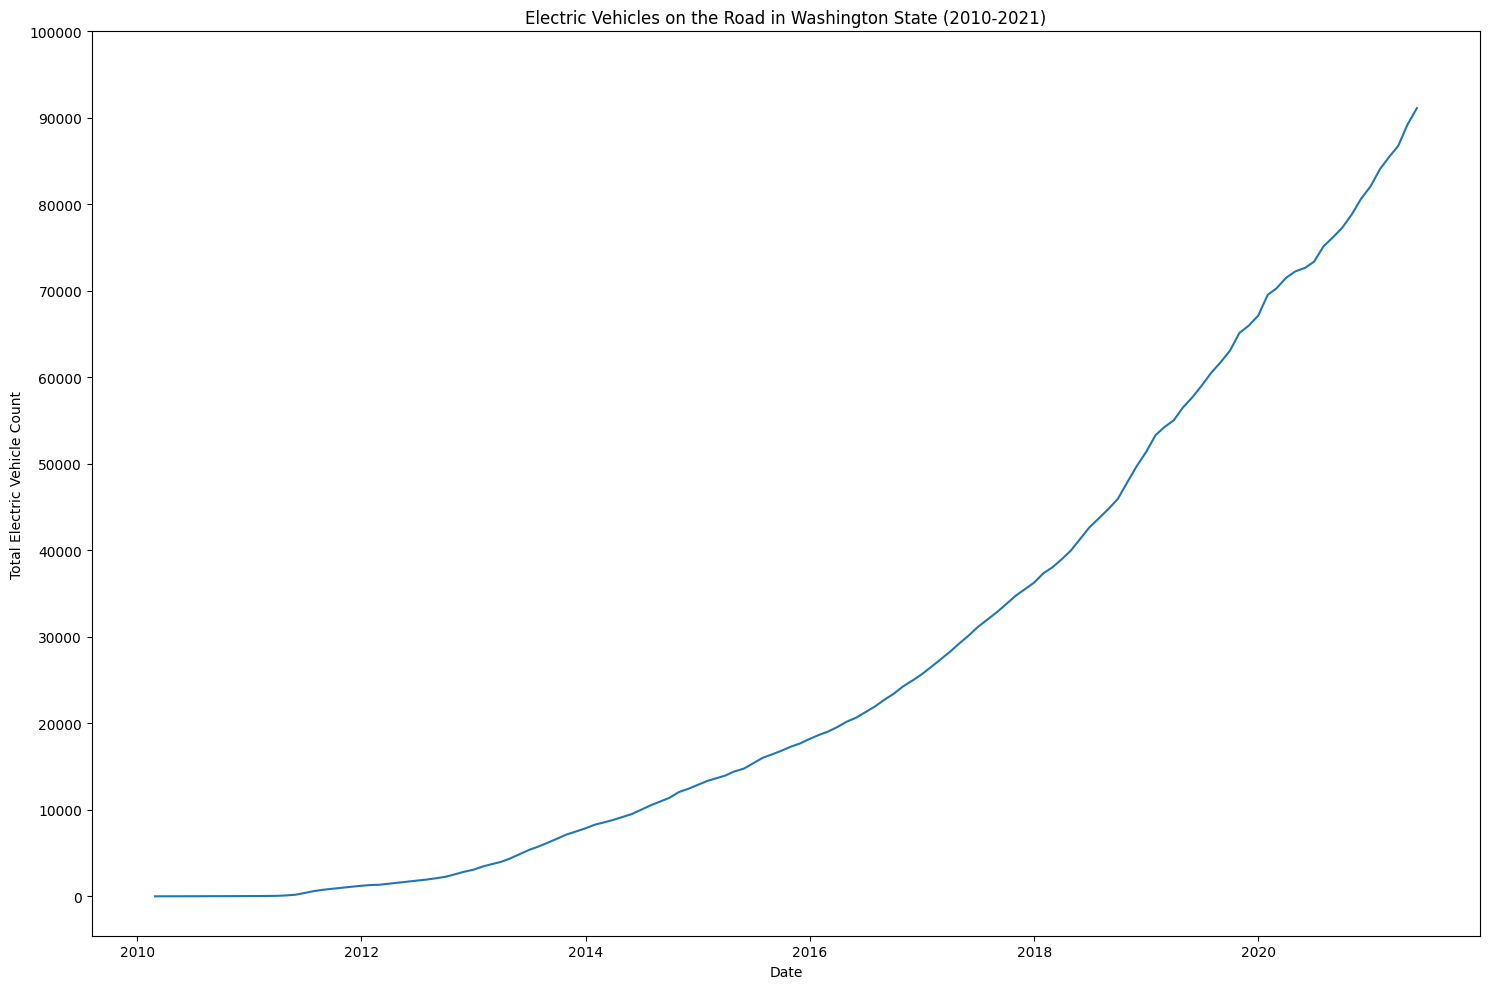

In [79]:
#plotting statewide EV Count
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,10))
sns.lineplot(x='transaction_date', y='State Total', data=df_cumsum, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Total Electric Vehicle Count')
ax.set_title('Electric Vehicles on the Road in Washington State (2010-2021)')
ax.set_yticks(range(0,110000,10000))
plt.tight_layout()
plt.savefig('/content/EV-Charger-Prediction/images/output_103_0.png', facecolor='white');

As we can see above, the amount of electric vehicles on Washington State roads have been increasing exponentially over the past 10 years. On a high level, this confirms that Washington State has the necessary demand trend for electric vehicles to make investing in it profitable for an EV charging company.

Since our data goes back as far as 2010, the count starts with 0 in 2010. However, it is important to note that this does not necessarily mean that there weren't any electric vehicles on the road in 2010. We are simply taking 2010 as our starting point and therefore the counts are relative.

## Electric Vehicles on the Road Over Time by County

Now that we looked at the statewide trend, we can start looking at individual counties. Since we have limited time for this analysis, we will be limiting our analysis to the top 10 counties that had the most electric vehicle purchases in the past 10 years.

In [80]:
df['county'].value_counts()

,count
county,
King,62119
Snohomish,12305
Pierce,8949
Clark,6155
Thurston,4110
Kitsap,4104
Whatcom,2963
Spokane,2575
Benton,1277


In [81]:
top_ten_counties = ['King', 'Snohomish', 'Pierce', 'Clark', 'Thurston',
                  'Kitsap', 'Whatcom', 'Spokane', 'Benton', 'Island']

In [82]:
#filtering out counties to keep top 10
df_cumsum = df_cumsum.loc[:, ['transaction_date', *top_ten_counties]]
df_cumsum.head()

,transaction_date,King,Snohomish,Pierce,Clark,Thurston,Kitsap,Whatcom,Spokane,Benton,Island
0,2010-02-28,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0
1,2010-03-31,1.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0,0.0
2,2010-04-30,2.0,0.0,0.0,1.0,0.0,1,1.0,1.0,0.0,0.0
3,2010-05-31,2.0,1.0,0.0,1.0,1.0,1,1.0,1.0,0.0,0.0
4,2010-06-30,3.0,1.0,0.0,1.0,1.0,1,1.0,1.0,0.0,0.0


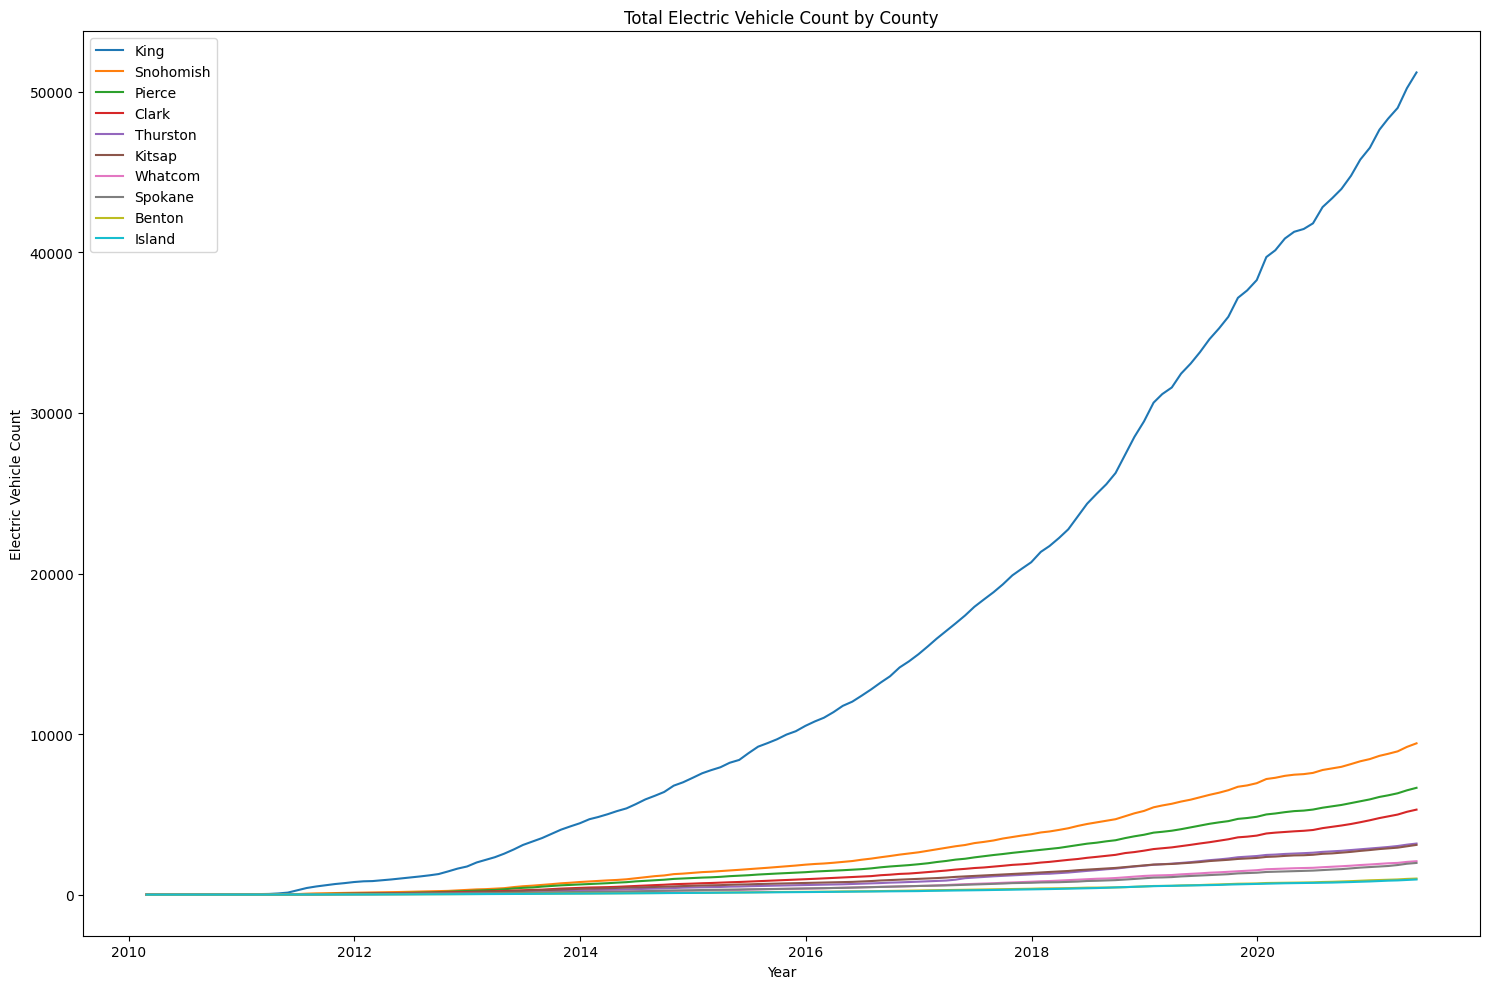

In [84]:
#plotting county trends
fig, ax = plt.subplots(figsize=(15,10))
for county in top_ten_counties:
    sns.lineplot(x='transaction_date', y=county, data=df_cumsum, ax=ax,
                 label=county)
ax.set_xlabel('Year')
ax.set_ylabel('Electric Vehicle Count')
ax.set_title('Total Electric Vehicle Count by County')
ax.legend()
# df_cumsum.plot()
plt.tight_layout();
plt.savefig('/content/EV-Charger-Prediction/images/output_110_0.png', facecolor='white')

Here, we can see that out of the top 10 most EV purchasing counties, King County has been growing much faster compared to others. This is expected since King County includes Seattle, which is the largest city by population in Washington State. Due to the scale differences between King County and the other 9 counties, it is difficult to see how these 9 counties compare to each other.

## Electric Vehicles on the Road Over Time (Excluding King County)

In [86]:
#plotting county trends except for King County
top_ten_counties.remove('King')

fig, ax = plt.subplots(figsize=(15,10))
for county in top_ten_counties:
    sns.lineplot(x='transaction_date', y=county, data=df_cumsum, ax=ax,
                 label=county)
ax.set_xlabel('Year')
ax.set_ylabel('Electric Vehicle Count')
ax.set_title('Total Electric Vehicle Count by County (Excluding King County)')
ax.set_yticks(range(0,11000,1000))
ax.legend()
plt.tight_layout();
plt.savefig('/content/EV-Charger-Prediction/images/output_113_1.png', facecolor='white')

ValueError: list.remove(x): x not in list

When we exclude King County, we can see that Snohomish County is leading the charge in electric vehicle purchases followed by Pierce and Clark County.

In [87]:
top_ten_counties += ['King']

## Most Purchased Car Models by County

Another important piece of information that can be relevant for an electric charging company is what the most purchased electric vehicle models are in each of these counties to decide on additional factors. These may include:

- Whether to include adapters for different connector types (Tesla, CCS, CHAdeMO etc.)
- What kind of charging station to build (level 1, level 2, level 3)
- Spacing of chargers based on the size of vehicles

In [88]:
def model_counts_by_county(df=df, top_n=10, county_list=top_ten_counties):

    """Function plots top n most purchased models as a bar plot for each of
    the counties provided.
    -------------------------------
    Arguments:
    df: class: pandas.DataFrame, default: df
    Dataframe containing title transactions for all counties.

    top_n: int, default: 10
    Number of most purchased models to plot.

    county_list: list, default: top_ten_counties
    The counties that will be analyzed.
    """

    fig, ax = plt.subplots(figsize=(10, 60), nrows=len(county_list))

    for i, county in enumerate(county_list):
        df_county = df[(df['county']==county) &
                       (df['transaction_type']=='Original Title')]
        model_count_df = pd.DataFrame(df_county['model'].value_counts()).reset_index()
        model_count_df.columns=['model', 'count']
        sns.barplot(x='model', y='count', data=model_count_df.head(top_n),
                    ax=ax[i])
        ax[i].set_title(f'Top {top_n} Most Purchased Models in {county} County (2010-2021)')
    plt.tight_layout();

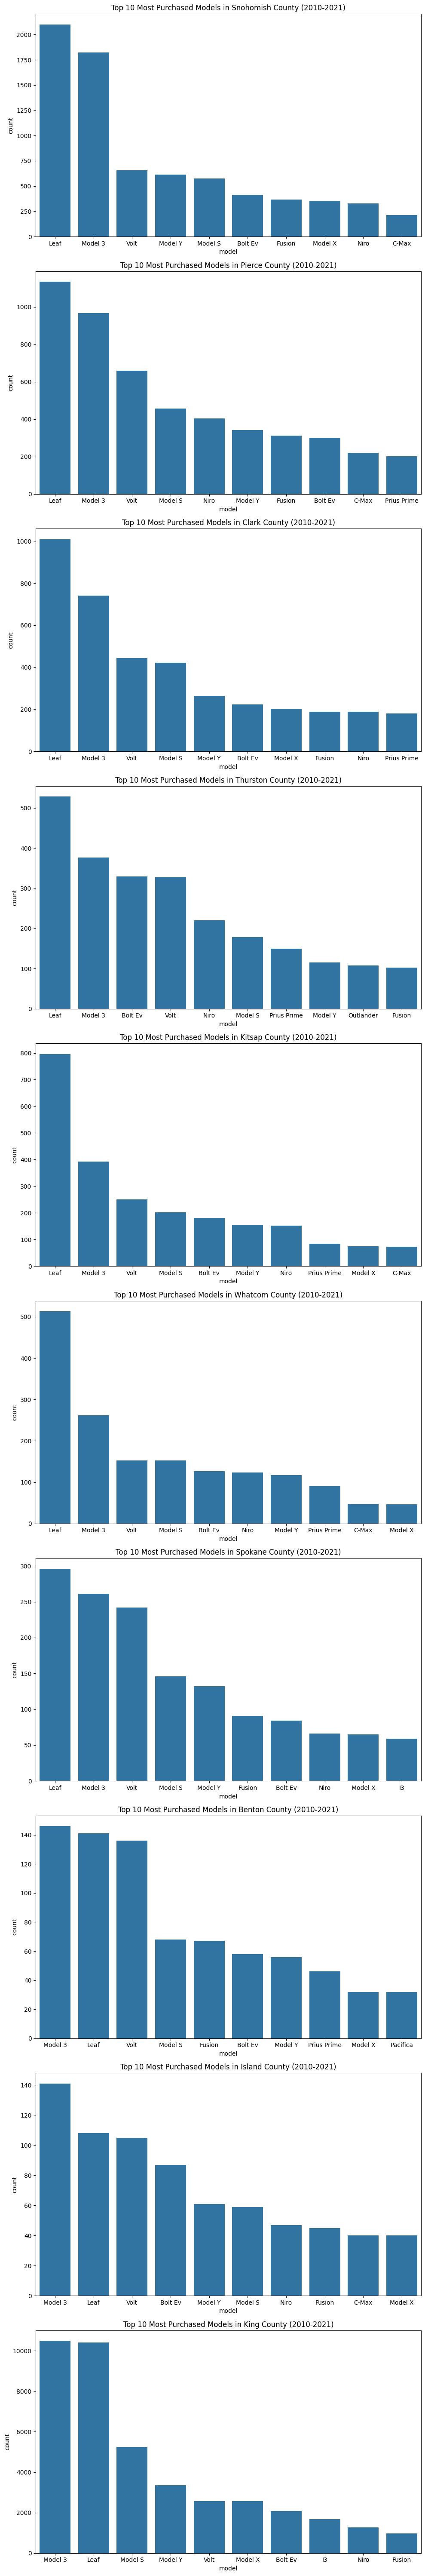

In [89]:
model_counts_by_county()
plt.savefig('/content/EV-Charger-Prediction/images/output_119_0.png', facecolor='white')

Nissan Leaf and Tesla Model 3 are the most purchased vehicles in each of these counties. Nissan Leaf was released in December 2010 and is widely considered to be the first mass-market electric vehicle. Tesla's Model 3 is a relatively lower priced luxury electric vehicle that was designed to appeal to the mass market as well. Considering these factors, it is not surprising that these vehicles are the most purchased vehicles in each county.

# MODEL

## Preprocessing/ Defining Functions

In [90]:
df_cumsum = df_cumsum.set_index('transaction_date').resample('M').asfreq()

<ipython-input-90-dbea14a83fe8>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_cumsum = df_cumsum.set_index('transaction_date').resample('M').asfreq()


In [91]:
df_cumsum.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 136 entries, 2010-02-28 to 2021-05-31
Freq: ME
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   King       136 non-null    float64
 1   Snohomish  136 non-null    float64
 2   Pierce     136 non-null    float64
 3   Clark      136 non-null    float64
 4   Thurston   136 non-null    float64
 5   Kitsap     136 non-null    int64  
 6   Whatcom    136 non-null    float64
 7   Spokane    136 non-null    float64
 8   Benton     136 non-null    float64
 9   Island     136 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 11.7 KB


### Separating Data for Each County

As discussed above, we will be creating time series models for the top ten counties. This requires us to break down the dataframe we have into smaller dataframes for each county.

In [92]:
def separate_data_by_county(county, df):
    """Function separates the given dataframe by county and returns the
    separated dataframe.
    -------------------------------
    Arguments:
    county: str
    Name of county that will be separated from the dataframe.

    df: class: pandas.DataFrame
    Dataframe that contains data for all counties. The specified county will
    be separated from this DataFrame.
    """

    df_county = pd.DataFrame(df.loc[:, county])
    df_county.columns=["EV's on the Road"]
    df_county.head()
    return df_county

In [93]:
#separating data by county and parsing this information to a dictionary
county_information = {}
for county in top_ten_counties:
    county_information[county] = {}
    county_information[county]['df']=separate_data_by_county(county, df_cumsum)

In [94]:
#separating data by county and parsing this information to a dictionary
county_dfs = {}
for county in top_ten_counties:
    county_dfs[county] = separate_data_by_county(county, df_cumsum)

### Functionizing the Evaluation of Models

Before modelling, one of the functions we will need is a function that will show us the various statistics so that we can evaluate the performance of the model.

In [95]:
def evaluate_model(model):
    """Function returns the model summary and diagnostics information to aid
    the evaluation of the given model's performance.
    -------------------------------
    Arguments:
    model: SARIMAX or ARIMA model object
    Model variable to evaluate (Time series models for both pmdarima and
    statsmodels are supported.
    """

    display(model.summary())
    model.plot_diagnostics()
    plt.tight_layout();

### Creating a Function for train_test_split & plotting

We will be splitting the time series into two: a training set and a testing set. This will allow us to validate the performance of the models.

In [96]:
def train_test_split_ts (df, train_size, test_size):

    """Function splits a given DataFrame into two sets based on the given
    train and test sizes so that the data can be used for validation.
    -------------------------------
    Arguments:
    df: class: pandas.DataFrame
    The base dataframe that will be getting split.

    train_size: float
    The size of the desired training set (for example: 0.80)

    test_size: float
    The size of the desired training set (for example: 0.20)
    """

    train_end_idx = int(round(len(df)*train_size,0))
    train_set = df.iloc[0:train_end_idx,:]["EV's on the Road"]
    test_set = df.iloc[train_end_idx:,:]["EV's on the Road"]
    return train_set, test_set

Additionally, to visualize these splits we will need a plotting function.

In [97]:
def plot_train_test_split(train_data, test_data, county):

    """Function plots the training and testing data for visual inspection.
    -------------------------------
    Arguments:
    train_data: pandas.Series
    The training set of data to be plotted.

    test_data: pandas.Series
    The test set of data to be plotted.

    county: str
    Name of the county that the training and testing data belongs to. This
    string is used to set the title of the axes.
    """

    train_data.plot(label='Train Data')
    test_data.plot(label='Test Data')
    ax=plt.gca()
    ax.set_xlabel('Year')
    ax.set_ylabel('Electric Vehicles on the Road')
    ax.set_title(f'Electric Vehicles on the Road in {county} County')
    ax.legend();

### Creating a Function for Getting Forecasts

For validation purposes we will be getting the forecast from our model for the test period and will be plotting it against the actual test data.

In [98]:
def get_forecast(model, train_data, test_data, plot=True):

    """Function gets forecasted values from a given model and plots them for
    visual inspection. The length of the forecasts are dependent on the length
    of the test data. The forecasted values are returned in a DataFrame format.
    -------------------------------
    Arguments:
    model:  SARIMAX or ARIMA model object
    Model that the forecast is to be received from.

    train_data: pandas.Series
    The training set of data used in training the model.

    test_data: pandas.Series
    The testing set of data used for validating the model.

    plot: bool, default=True
    Option to plot the forecasted values along with observed values
    (train_data and test_data).
    """

    #creating a df with the forecast information
    forecast_df = model.get_forecast(steps=len(test_data)).conf_int()
    forecast_df.columns = ['Lower Confidence Interval',
                              'Upper Confidence Interval']
    forecast_df['Forecasts'] = model.get_forecast(steps=len(test_data))\
    .predicted_mean
    #plotting
    if plot==True:
        with plt.style.context('seaborn-whitegrid'):
            fig, ax = plt.subplots(figsize=(15, 10))
            sns.lineplot(data=train_data, color='black', ax=ax)
            sns.lineplot(data=forecast_df, x=forecast_df.index,
                         y='Forecasts', color='blue', ax=ax,
                         label='Forecasted Data', ls='--')
            sns.lineplot(data=test_data, color='purple', ax=ax,
                         label='Actual Data', ls='-.')
            ax.fill_between(forecast_df.index,
                            y1=forecast_df['Lower Confidence Interval'],
                            y2=forecast_df['Upper Confidence Interval'],
                            color = 'green', alpha=0.3,
                            label='Confidence Interval')
            ax.set_xlabel('Year')
            ax.legend(loc=2)
            plt.show();
    return forecast_df

### Defining a Function for Getting Predictions for Future

Lastly, we will also be needing a function similar to the get_forecast function that will be used for getting predictions for the future and plotting for visualization.

In [99]:
def get_prediction(model, df, test_data, county_name, plot=True):

    """Function gets predicted values from a given model and plots them for
    visual inspection. The length of the predictions are dependent on the
    length of the test data. The forecasted values are returned in a DataFrame
    format.
    -------------------------------
    Arguments:
    model:  SARIMAX or ARIMA model object
    Model to be used for making predictions.

    df: pandas.DataFrame
    DataFrame that contains all observed data.

    test_data: pandas.Series
    The testing set of data used for validating the model (dictates the length
    of predictions).

    plot: bool, default=True
    Option to plot the predicted values along with observed values.
    """

    #creating a df with the prediction information
    prediction_df = model.get_forecast(steps=len(test_data)).conf_int()
    prediction_df.columns = ['Lower Confidence Interval',
                              'Upper Confidence Interval']
    prediction_df['Predictions'] = model.get_forecast(steps=len(test_data))\
    .predicted_mean
    #plotting
    if plot==True:
        with plt.style.context('seaborn-whitegrid'):
            fig, ax = plt.subplots(figsize=(15, 10))
            sns.lineplot(data=df, ax=ax)
            sns.lineplot(data=prediction_df, x=prediction_df.index,
                         y='Predictions', color='orange', ax=ax,
                         label='Predicted Data', ls='--')
            ax.fill_between(prediction_df.index,
                            y1=prediction_df['Lower Confidence Interval'],
                            y2=prediction_df['Upper Confidence Interval'],
                            color = 'green', alpha=0.3,
                            label='Confidence Interval')
            ax.set_xlabel('Year')
            ax.set_ylabel('Electric Vehicles on the Road')
            ax.set_title(f'Predicted Electric Vehicle Count for {county_name}')
            plt.show();
    return prediction_df

## King County

### Seasonality Check

Prior to starting modeling, it is important to decompose the data to get a better sense of the trend and seasonality components of it.

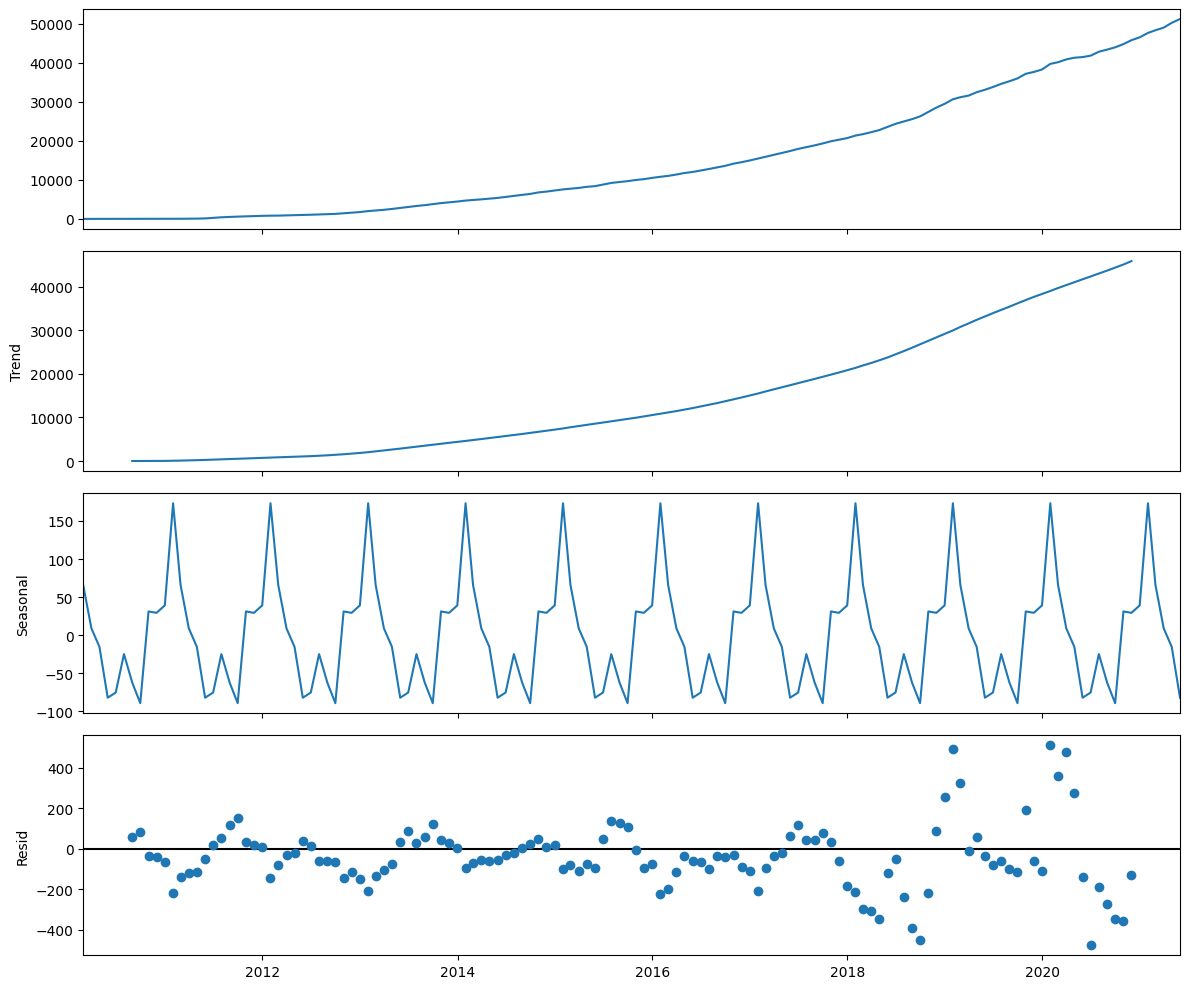

In [100]:
import statsmodels.tsa.api as tsa

plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['King']['df'])
decomp.plot();

Not surprisingly, the electric vehicle count for King County has an upward trend. Additionally, we can see that there is seasonality to the data as well. We can now move onto creating the training and testing sets for validation.

### train_test_split

After multiple iterations, we found that the 0.80-0.20 split of the data belonging to King County resulted in the best performance.

In [101]:
#splitting dataset into train and test sets for validation
train_king, test_king = train_test_split_ts(county_information['King']['df'],
                                            0.80, 0.20)

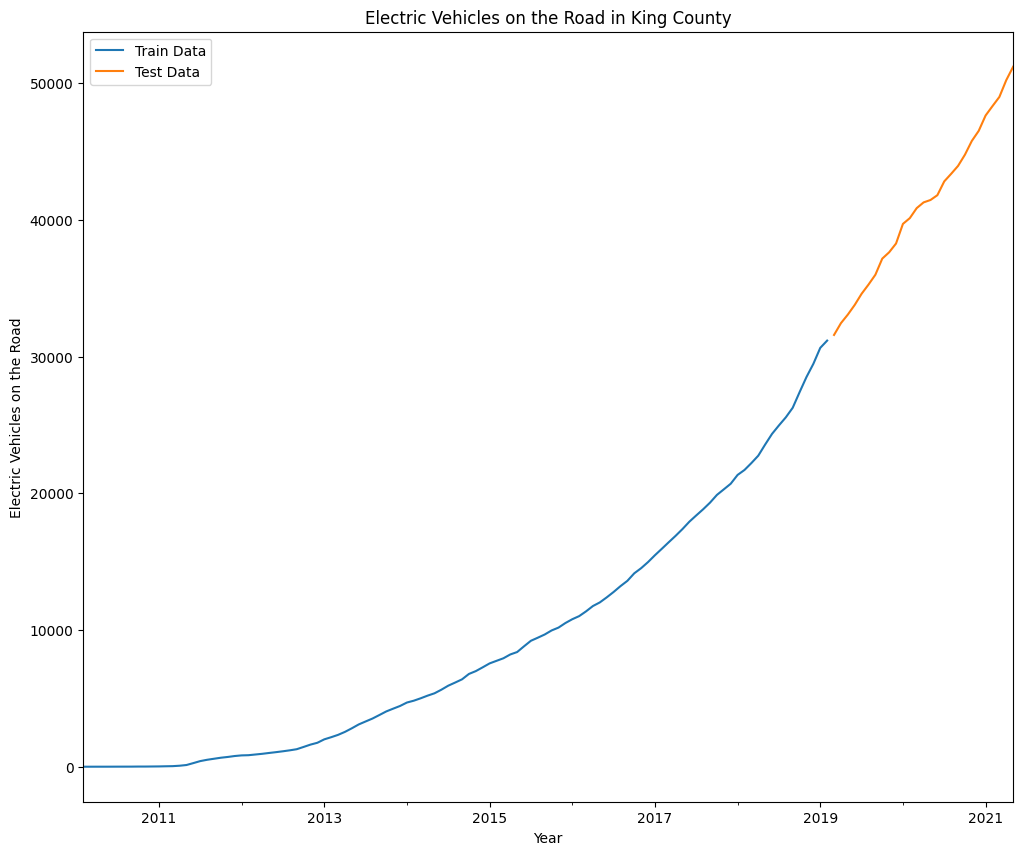

In [102]:
#plotting the split
plot_train_test_split(train_king, test_king, 'King')

### Finding Best Parameters with Auto-Arima

To have a model that can accurately predict future values, we need to optimize the p,d,q values of the models for each county and validate. In order to achieve this programmatically, we will be using the pmdarima library.

In [106]:
!pip install pmdarima --quiet
import pmdarima as pm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.8 MB/s eta 0:00:00


In [107]:
auto_model = pm.auto_arima(train_king, start_p=0, d=1, start_q=0, max_p=4,
                           max_d=3, max_q=4, start_P=0, start_Q=0, max_P=3,
                           max_D=3, max_Q=3, m=12)
auto_model.summary()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  109
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -570.311
Date:                            Thu, 20 Feb 2025   AIC                           1146.622
Time:                                    09:19:46   BIC                           1154.315
Sample:                                02-28-2010   HQIC                          1149.732
                                     - 02-28-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     26.5075     13.389      1.980      0.048       0.265      52.750
ar.L1          0.7305      0.051     14.288      0.000       0.630       0.831
sigma2      8406.5771    814.661     10.319      0.000    6809.871       1e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                61.47
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               7.72   Skew:                             0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best parameters (based on the AIC score) were (1,1,0) for the ARIMA order and (0,1,0,12) for the seasonal component. We can go ahead and plug these into a SARIMAX model to have our final model and then we can validate it by looking at the forecasts and the test set.

### Validate Model with Forecasts for Test Data

In [108]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  109
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -567.043
Date:                            Thu, 20 Feb 2025   AIC                           1138.087
Time:                                    09:20:03   BIC                           1143.195
Sample:                                02-28-2010   HQIC                          1140.151
                                     - 02-28-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8305      0.042     20.002      0.000       0.749       0.912
sigma2      8954.2159    822.909     10.881      0.000    7341.344    1.06e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.66   Jarque-Bera (JB):                42.89
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               7.52   Skew:                             0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

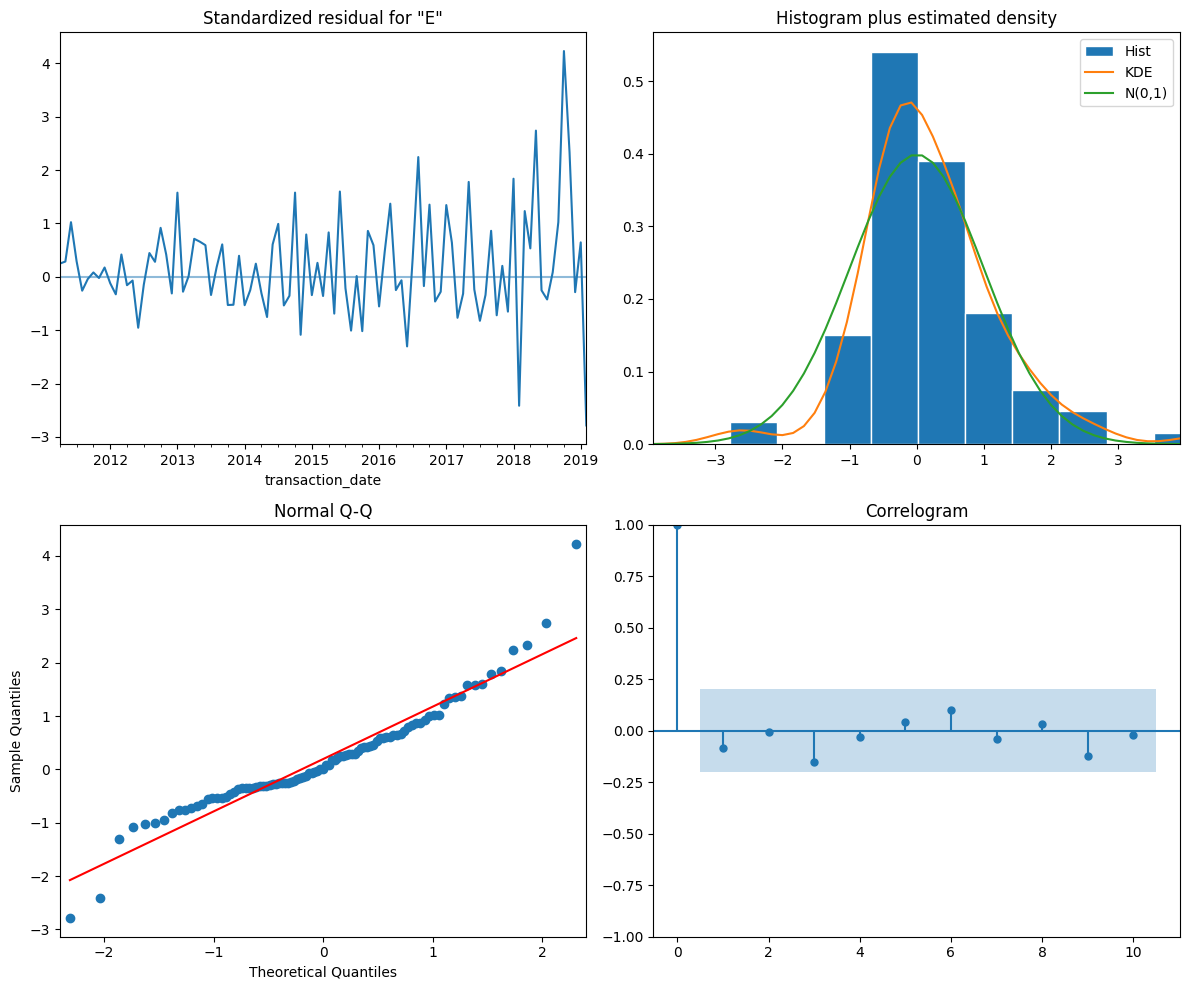

In [109]:
model = SARIMAX(train_king, order=(1,1,0),
                seasonal_order=(0,1,0,12), enforce_invertibility=False,
                enforce_stationarity=False).fit()
evaluate_model(model)

Here, looking at the residual information, we can see that they are very close to having a normal distribution. Additionally, there is no longer an obvious seasonality based on the correlogram and the standardized residuals. The coefficient p-values also suggest that they are statistically significant. These results suggest that the model is satisfactory to move onto validation.

In [110]:
df_king_forecast = get_forecast(model, train_king, test_king, plot=True)

OSError: 'seaborn-whitegrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

Above, we can see that the model is able to accurately forecast data into the future. The actual observed data is well within the confidence interval of our model's forecasts.

### Future Predictions

#### Fitting Model to All Observed Data

Now that we know that our model can accurately make predictions about the future electric vehicle counts in each county, we can use the same parameters to build a model on the whole observed dataset without splitting it into train/test sets.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  136
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -818.139
Date:                            Thu, 20 Feb 2025   AIC                           1640.277
Time:                                    09:21:27   BIC                           1645.885
Sample:                                02-28-2010   HQIC                          1642.555
                                     - 05-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4919      0.062      7.989      0.000       0.371       0.613
sigma2      3.911e+04   2910.227     13.440      0.000    3.34e+04    4.48e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.72   Jarque-Bera (JB):               108.03
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):              26.48   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

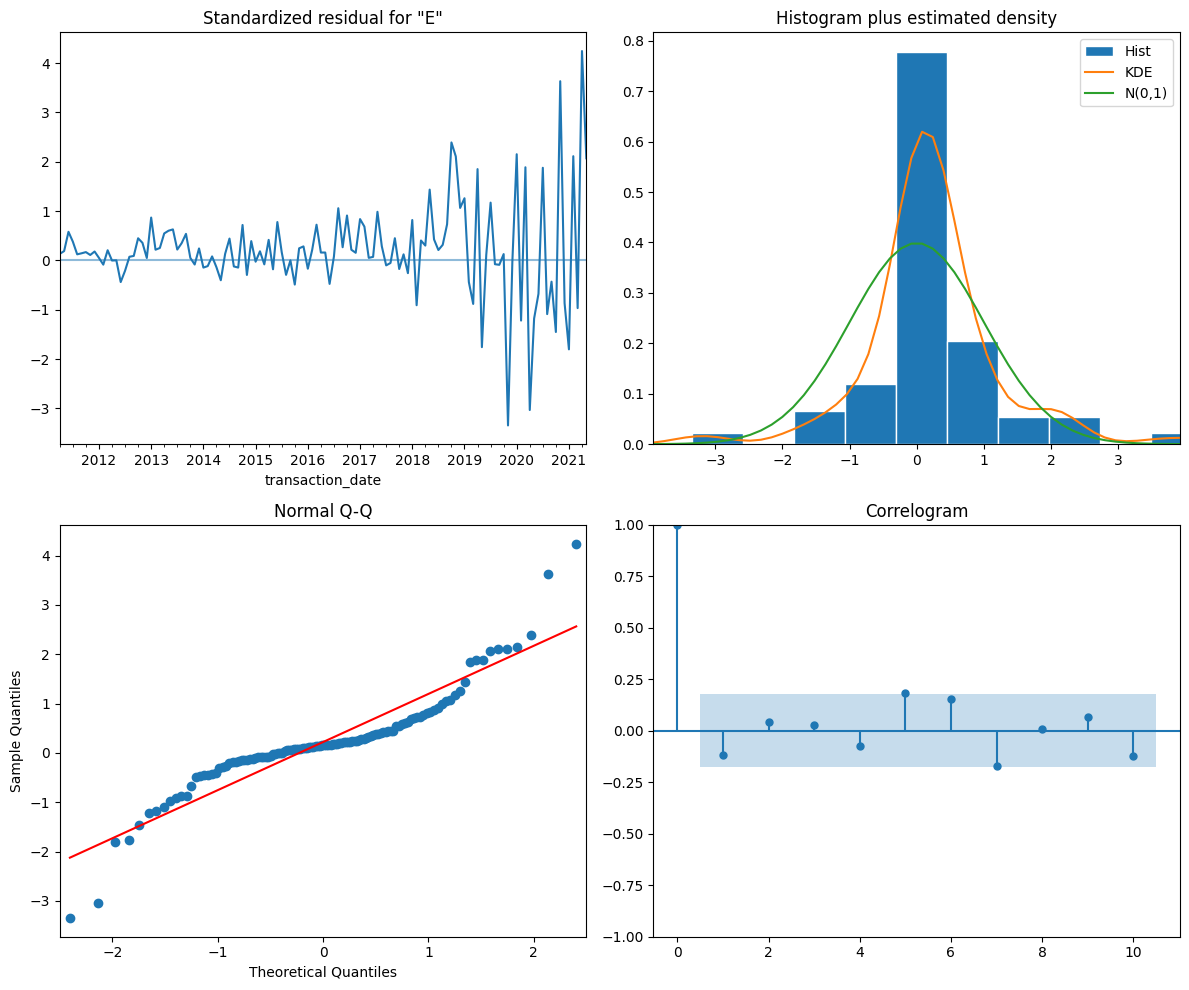

In [111]:
model = SARIMAX(county_information['King']['df'], order=(1,1,0),
                seasonal_order=(0,1,0,12), enforce_invertibility=False,
                enforce_stationarity=False).fit()
evaluate_model(model)

Above we can see that the residuals for this model are less normally distributed compared to the test model. However, they are still fairly close to having a normal distribution. Additionally, there is no longer an obvious seasonality based on the correlogram and the standardized residuals. The coefficient p-values also suggest that they are statistically significant.

#### Plotting & Saving Predictions

Using our model, we can predict the future counts of electric vehicles in King County and plot them.

In [112]:
#creating a df of predictions and plotting
df_king_preds = get_prediction(model, county_information['King']['df'],
                               test_king, 'King', plot=True)

OSError: 'seaborn-whitegrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

The model is predicting that the amount of electric vehicles in King County are going to keep increasing almost linearly based on the mean values. If we look at the upper confidence interval though, we can see that the increase could keep an exponential pattern.

In [113]:
#saving predictions df to dict for later use
county_information['King']['Predictions'] = df_king_preds

NameError: name 'df_king_preds' is not defined

## Snohomish County

### Seasonality Check

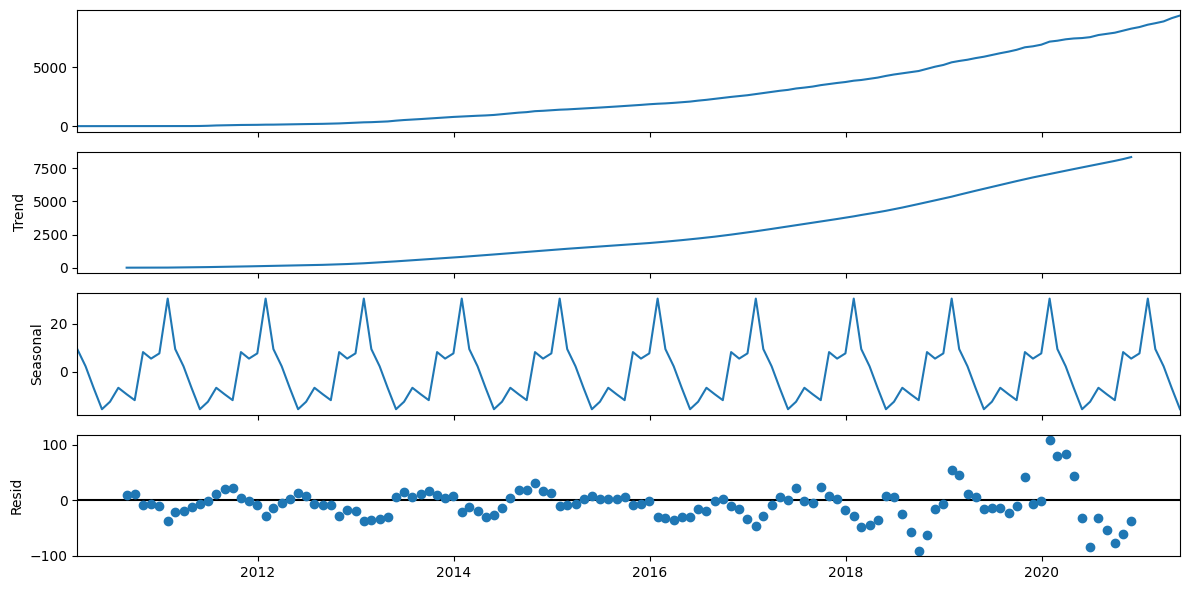

In [114]:
plt.rcParams['figure.figsize']=(12,6)
decomp = tsa.seasonal_decompose(county_information['Snohomish']['df'])
decomp.plot();

Above we can see that there is a clear trend upwards in electric vehicle counts in Snohomish county. Additionally, we can see that there is a relatively small seasonality to it.

### train_test_split

After multiple iterations, we found that the 0.75-0.25 split of the data belonging to Snohomish County resulted in the best performance.

In [115]:
#splitting dataset into train and test sets for validation
train_sno, test_sno = train_test_split_ts(county_information['Snohomish']['df'],
                                          0.75, 0.25)

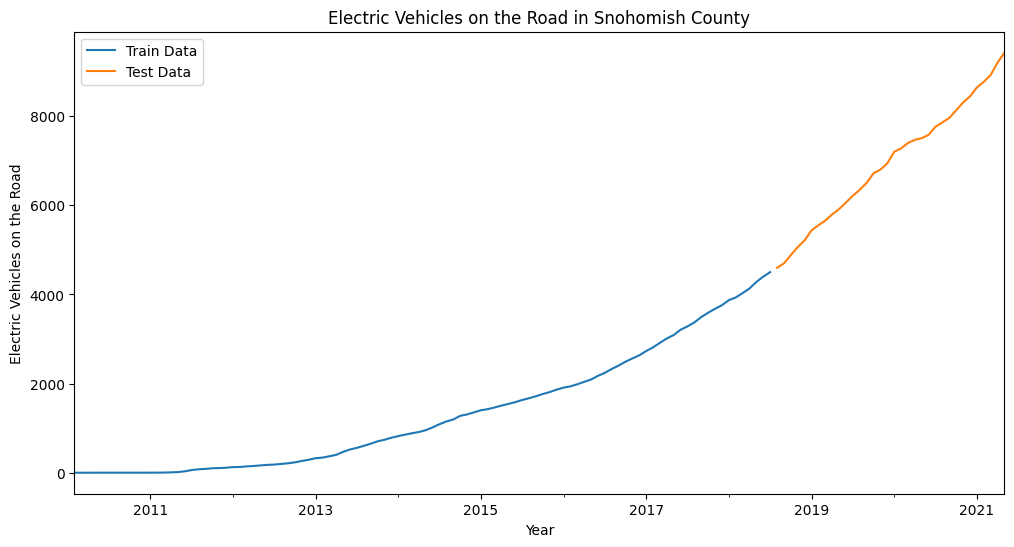

In [116]:
#plotting train and test sets
plot_train_test_split(train_sno, test_sno, 'Snohomish')

### Finding Best Parameters with Auto-Arima

In [117]:
#finding best parameters
auto_model = pm.auto_arima(train_sno, start_p=0, start_q=0, d=1, max_p=4,
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0,
                           m=12, verbose=2)
auto_model.summary()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  102
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -408.630
Date:                            Thu, 20 Feb 2025   AIC                            827.260
Time:                                    09:23:25   BIC                            840.336
Sample:                                02-28-2010   HQIC                           832.553
                                     - 07-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9945      0.008    119.139      0.000       0.978       1.011
ma.L1         -0.6253      0.099     -6.310      0.000      -0.820      -0.431
ar.S.L12       0.8995      0.205      4.396      0.000       0.498       1.300
ma.S.L12      -0.7499      0.292     -2.571      0.010      -1.321      -0.178
sigma2       178.2376     26.275      6.784      0.000     126.741     229.735
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):                19.59
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               7.73   Skew:                             0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best parameters (based on the AIC score) were (1,1,1) for the ARIMA order and (1,0,1,12) for the seasonal component. We can go ahead and plug these into a SARIMAX model to have our final model and then we can validate it by looking at the forecasts and the test set.

### Validate Model with Forecasts for Test Data

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  102
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -356.437
Date:                            Thu, 20 Feb 2025   AIC                            722.874
Time:                                    09:23:26   BIC                            735.203
Sample:                                02-28-2010   HQIC                           727.839
                                     - 07-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0092      0.011     93.361      0.000       0.988       1.030
ma.L1         -0.6876      0.111     -6.190      0.000      -0.905      -0.470
ar.S.L12       0.8889      0.159      5.585      0.000       0.577       1.201
ma.S.L12      -0.7052      0.291     -2.423      0.015      -1.276      -0.135
sigma2       193.1000     45.868      4.210      0.000     103.200     283.000
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 6.99
Prob(Q):                              0.90   Prob(JB):                         0.03
Heteroskedasticity (H):               3.33   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

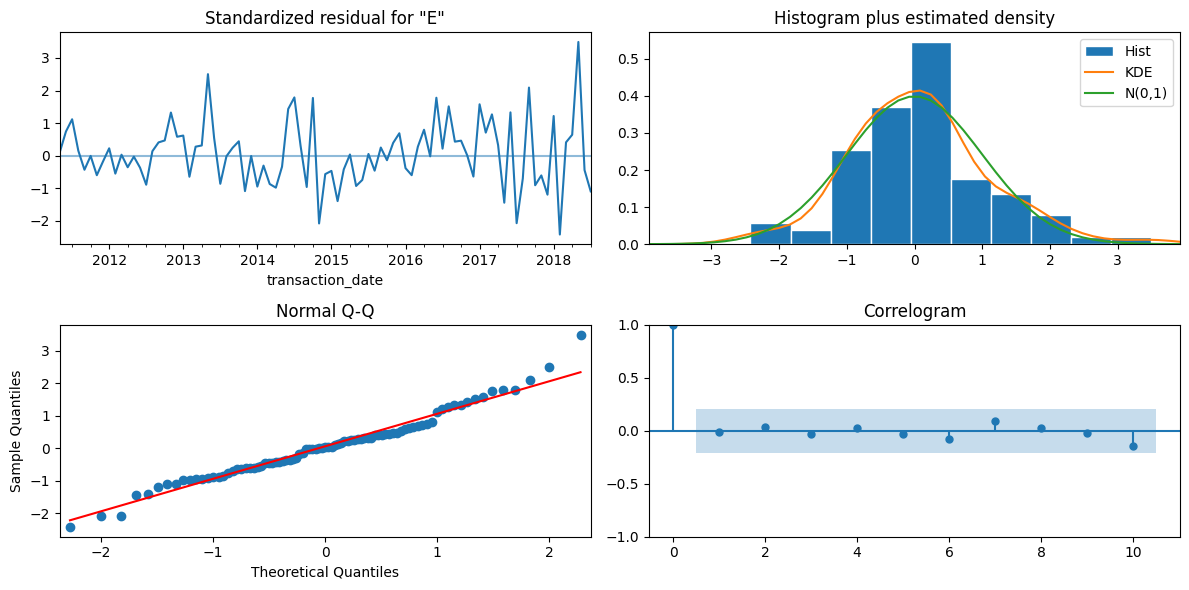

In [118]:
#fitting SARIMAX model with best params
model = SARIMAX(train_sno, order=(1,1,1), seasonal_order=(1,0,1,12),
                enforce_invertibility=False, enforce_stationarity=False).fit()
evaluate_model(model)

Above, we can see that the residuals are almost perfectly normally distributed. This indicates that the parameters we chose worked in removing the trend and the seasonality of the data. Next, we can move onto visually validating the model.

In [119]:
df_sno_forecast = get_forecast(model, train_sno, test_sno, plot=True)

OSError: 'seaborn-whitegrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

The model's forecasts initially are very close to the actual observations. Even though they diverge between mid-2018 to mid-2020, the actual data stays within the confidence interval and converges back to the forecasted values almost perfectly.  

### Future Predictions

Once again, we can use the same parameters found above for the entire observed data to make predictions on future values.

#### Fitting Model to All Observed Data

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  136
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -588.502
Date:                            Thu, 20 Feb 2025   AIC                           1187.003
Time:                                    09:24:22   BIC                           1200.982
Sample:                                02-28-2010   HQIC                          1192.681
                                     - 05-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0134      0.012     82.920      0.000       0.989       1.037
ma.L1         -0.6489      0.056    -11.528      0.000      -0.759      -0.539
ar.S.L12       0.6429      0.362      1.777      0.076      -0.066       1.352
ma.S.L12      -0.3485      0.375     -0.930      0.352      -1.083       0.386
sigma2       971.7472     78.312     12.409      0.000     818.259    1125.236
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               126.91
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):              19.64   Skew:                             0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

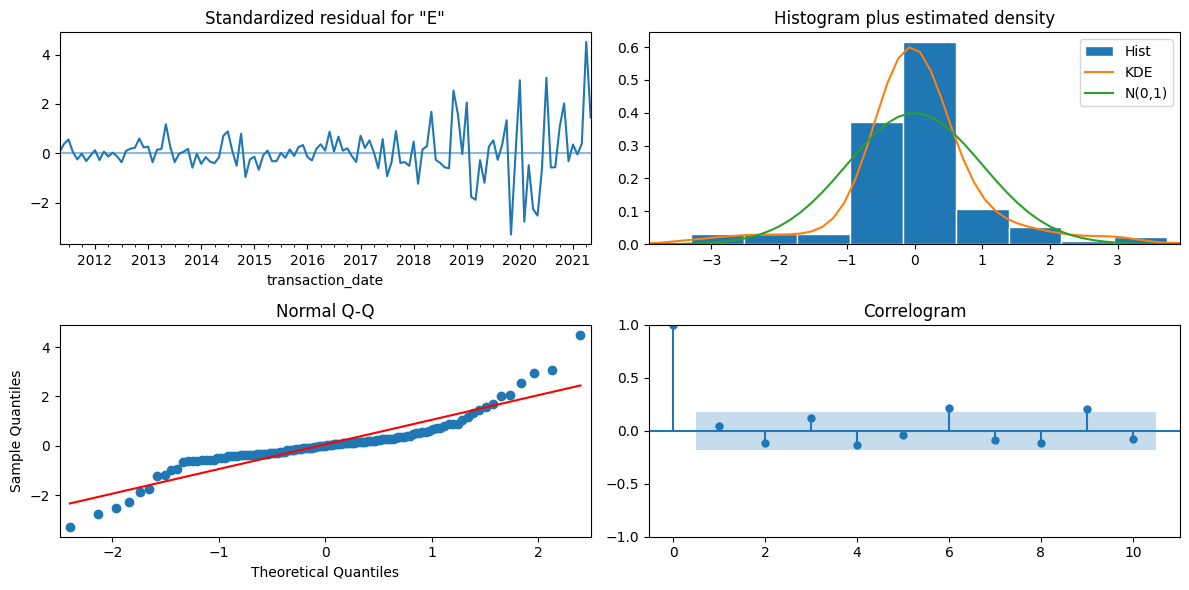

In [120]:
model = SARIMAX(county_information['Snohomish']['df'], order=(1,1,1),
                seasonal_order=(1,0,1,12), enforce_invertibility=False,
                enforce_stationarity=False).fit()
evaluate_model(model)

We can see that the residuals are once again fairly close to being normally distributed. We can accept this as the best model and move onto making and plotting predictions.

#### Plotting & Saving Predictions

In [121]:
#getting and plotting predictions
df_sno_preds = get_prediction(model, county_information['Snohomish']['df'],
                               test_sno, 'Snohomish', plot=True)

OSError: 'seaborn-whitegrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

The model is predicting that the amount of electric vehicles in Snohomish county are going to keep rising in an exponential pattern.

In [122]:
#saving predictions
county_information['Snohomish']['Predictions'] = df_sno_preds

NameError: name 'df_sno_preds' is not defined

## Pierce County

### Seasonality Check

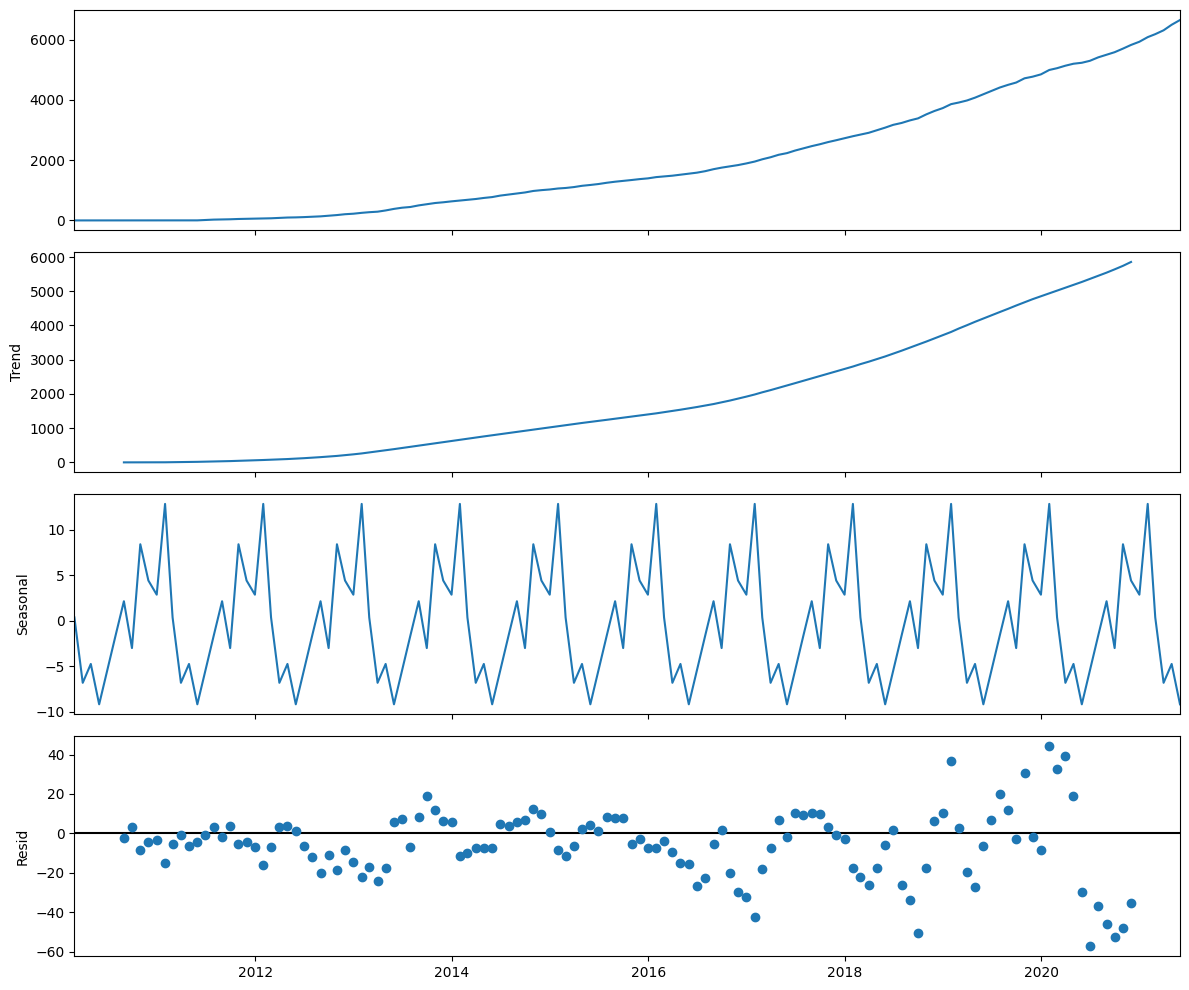

In [123]:
plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['Pierce']['df'])
decomp.plot();

We can see here that there is a clear upwards trend in the amount of electric vehicles in Pierce County. Additionally, there seems to be a relatively small seasonal component to the data as well.

### train_test_split

After multiple iterations, we found that the 0.75-0.25 split of the data belonging to Pierce County resulted in the best performance.

In [124]:
#splitting dataset into train and test sets for validation
train_pierce, test_pierce = train_test_split_ts(county_information['Pierce']['df'],
                                            0.75, 0.25)

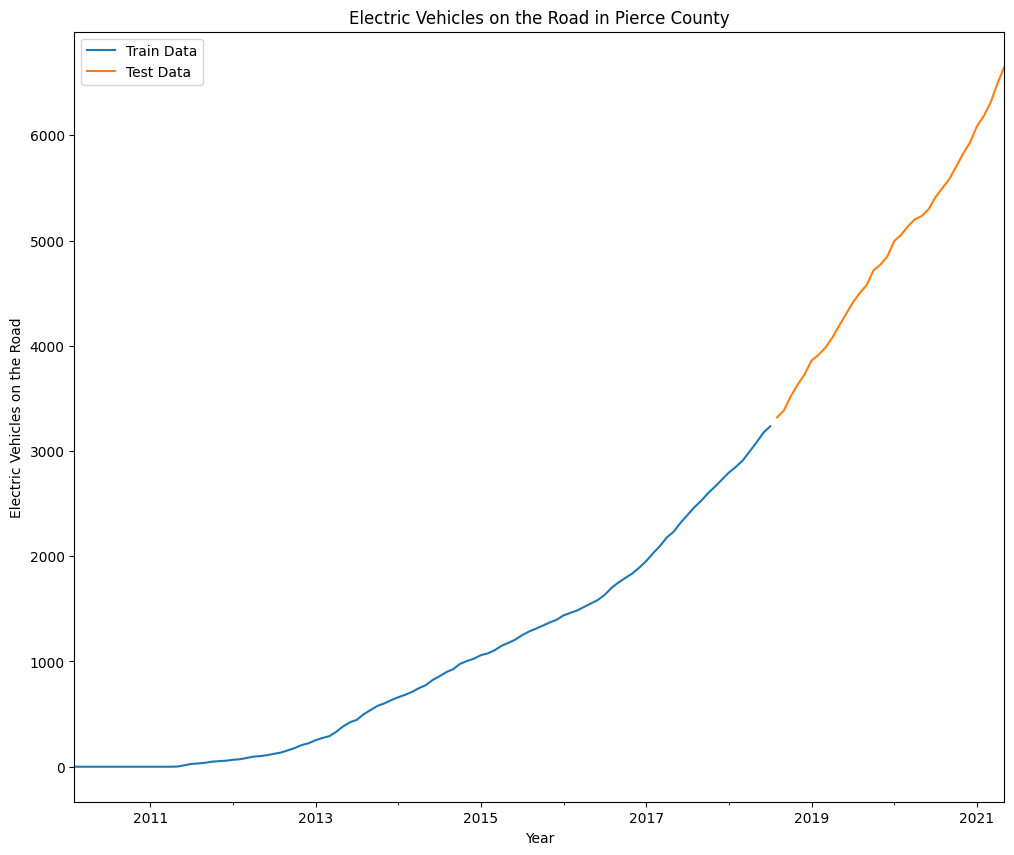

In [125]:
#plotting train and test sets
plot_train_test_split(train_pierce, test_pierce, 'Pierce')

### Finding Best Parameters with Auto-Arima

In [126]:
auto_model = pm.auto_arima(train_pierce, start_p=0, start_q=0, d=1, max_p=4,
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0,
                           m=12, verbose=2)
auto_model.summary()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  102
Model:             SARIMAX(4, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -370.851
Date:                            Thu, 20 Feb 2025   AIC                            757.702
Time:                                    09:25:56   BIC                            778.623
Sample:                                02-28-2010   HQIC                           766.172
                                     - 07-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0045      0.257     -0.018      0.986      -0.508       0.499
ar.L2          0.4164      0.166      2.510      0.012       0.091       0.742
ar.L3          0.1793      0.116      1.542      0.123      -0.049       0.407
ar.L4          0.3758      0.090      4.183      0.000       0.200       0.552
ma.L1          0.5275      0.263      2.008      0.045       0.013       1.042
ar.S.L12       0.9433      0.226      4.165      0.000       0.499       1.387
ma.S.L12      -0.8278      0.383     -2.161      0.031      -1.579      -0.077
sigma2        83.7706     12.528      6.687      0.000      59.217     108.324
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 2.82
Prob(Q):                              0.71   Prob(JB):                         0.24
Heteroskedasticity (H):               7.29   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best parameters (based on the AIC score) were (4,1,1) for the ARIMA order and (1,0,1,12) for the seasonal component. We can go ahead and plug these into a SARIMAX model to have our final model and then we can validate it by looking at the forecasts and the test set.

### Validate Model with Forecasts for Test Data

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   EV's on the Road   No. Observations:                  102
Model:             SARIMAX(4, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -317.231
Date:                            Thu, 20 Feb 2025   AIC                            650.461
Time:                                    09:25:56   BIC                            670.002
Sample:                                02-28-2010   HQIC                           658.321
                                     - 07-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0542      0.259      0.210      0.834      -0.453       0.561
ar.L2          0.3434      0.178      1.934      0.053      -0.005       0.692
ar.L3          0.1405      0.117      1.202      0.230      -0.089       0.370
ar.L4          0.4383      0.101      4.334      0.000       0.240       0.637
ma.L1          0.4723      0.281      1.678      0.093      -0.079       1.024
ar.S.L12       0.9835      0.089     11.016      0.000       0.809       1.159
ma.S.L12      -1.0000   1376.635     -0.001      0.999   -2699.155    2697.155
sigma2        75.8312   1.04e+05      0.001      0.999   -2.05e+05    2.05e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 2.57
Prob(Q):                              0.83   Prob(JB):                         0.28
Heteroskedasticity (H):               2.05   Skew:                             0.40
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

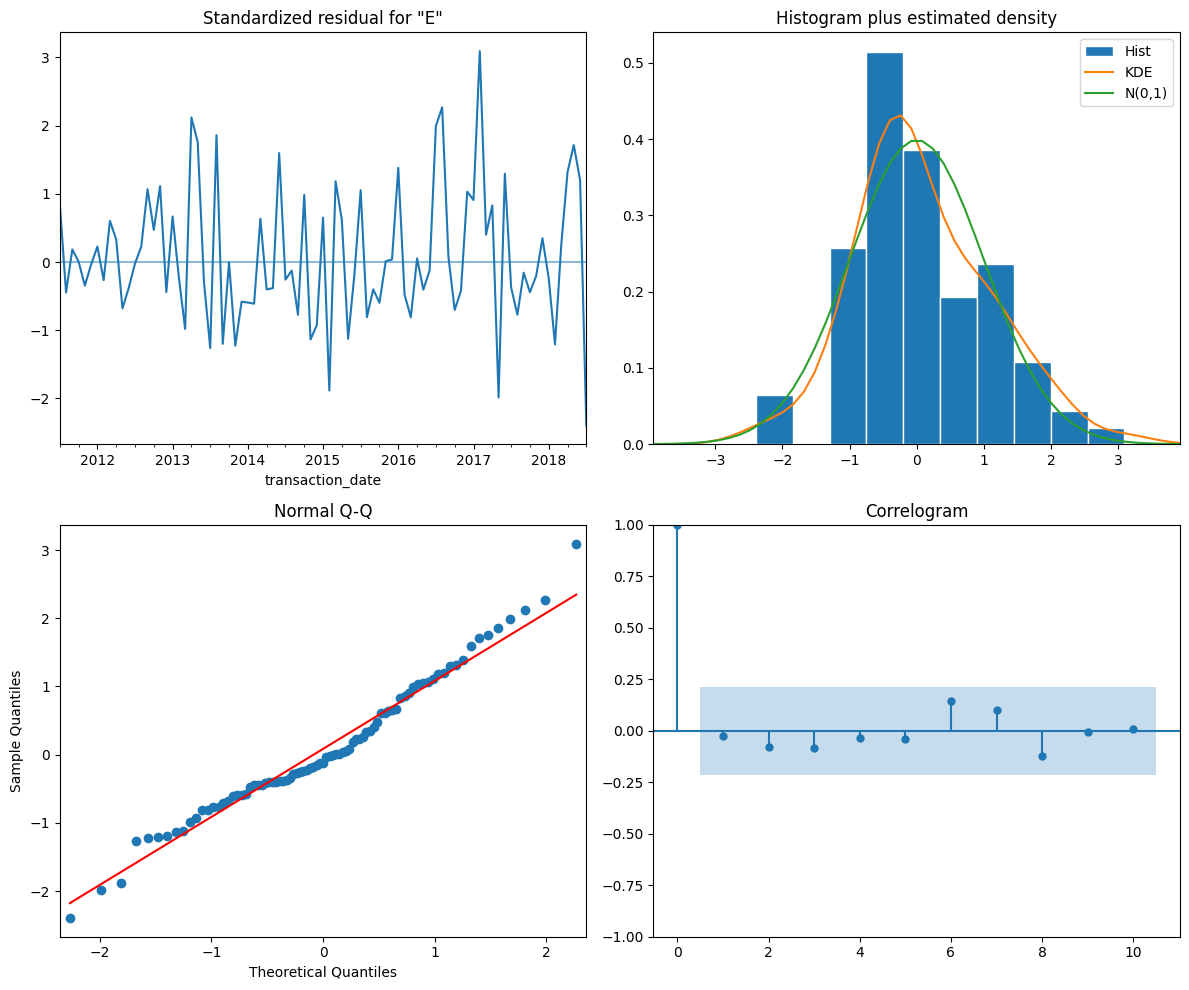

In [127]:
#fitting SARIMAX model with best params
model = SARIMAX(train_pierce, order=(4,1,1), seasonal_order=(1,0,1,12),
                enforce_invertibility=False, enforce_stationarity=False).fit()
evaluate_model(model)

Above, we can see that the residuals are almost perfectly normally distributed. This indicates that the parameters chosen above were successful in removing the seasonality and the trend. Additionally, even though some of the coefficients have values higher than 0.05 (our chosen alpha value), based on the AIC score these parameters resulted in the best model. So we will be moving on with this model.

In [128]:
df_pierce_forecast = get_forecast(model, train_pierce, test_pierce, plot=True)

OSError: 'seaborn-whitegrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

Here, we can see that the forecasted data stays lower than the actual observed data. However, the observed data is still within our confidence interval. Therefore, we can move onto fitting the model to all observed data.

### Future Predictions

#### Fitting Model to All Observed Data

In [ ]:
model = SARIMAX(county_information['Pierce']['df'], order=(4,1,1),
                seasonal_order=(1,0,1,12), enforce_invertibility=False,
                enforce_stationarity=False).fit()
evaluate_model(model)

Once again, looking at the residuals, we can see that they have a fairly normal distribution. Even though some of the p-values are once again higher than the 0.05 threshold, the parameters seem to generate a model that can accurately predict the future values.

#### Plotting & Saving Predictions

In [ ]:
#getting and plotting predictions
df_pierce_preds = get_prediction(model, county_information['Pierce']['df'],
                               test_pierce, 'Pierce', plot=True)

Our model is predicting that the growth in electric vehicles in Pierce County will keep an exponential growth pattern for the next few years.

In [ ]:
#saving predictions
county_information['Pierce']['Predictions'] = df_pierce_preds

## Clark County

### Seasonality Check

In [ ]:
plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['Clark']['df'])
decomp.plot();

As is the case with the previous counties, the decomposition for Clark County's data also suggests that there is an upwards trend and a seasonal component.

### train_test_split

After multiple iterations, we found that the 0.75-0.25 split of the data belonging to Clark County resulted in the best performance.

In [ ]:
#split data into train/test sets for validation
train_clark, test_clark = train_test_split_ts(county_information['Clark']['df'],
                                            0.75, 0.25)

In [ ]:
#plot the split
plot_train_test_split(train_clark, test_clark, 'Clark')

### Finding Best Parameters with Auto-Arima

In [ ]:
auto_model = pm.auto_arima(train_clark, start_p=0, start_q=0, d=1, max_p=4,
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0,
                           m=12, verbose=2)
auto_model.summary()

The best parameters (based on the AIC score) were (1,1,2) for the ARIMA order and (1,0,[],12) for the seasonal component. We can go ahead and plug these into a SARIMAX model to have our final model and then we can validate it by looking at the forecasts and the test set.

### Validate Model with Forecasts for Test Data

In [ ]:
model = SARIMAX(train_clark, order=(1,1,2), seasonal_order=(1,0,[],12),
                enforce_invertibility=False, enforce_stationarity=False).fit()
evaluate_model(model)

The residuals are nearly normally distributed and based on the correlogram, the model was able to remove seasonality successfully.

In [ ]:
df_clark_forecast = get_forecast(model, train_clark, test_clark, plot=True)

The model's forecast stays inline with the observed data from mid-2018 to early 2020. Around March of 2020, the observed data is lower than the forecasts. This may be due to the COVID-19 pandemic that affected much of the US at this date. Even though this is the case, the observed data stays well within the confidence interval. This indicates that our model is performing very well and that we can move onto fitting the model to all the observed data to make predictions on future values.

### Future Predictions

#### Fitting Model to All Observed Data

In [ ]:
model = SARIMAX(county_information['Clark']['df'], order=(1,1,2),
                seasonal_order=(1,0,[],12), enforce_invertibility=False,
                enforce_stationarity=False).fit()
evaluate_model(model)

The residuals are once again fairly normally distributed except for the portion of early 2020 to today. As discussed above, this may be due to the COVID-19 pandemic and the shutdowns that affected almost all industries including the electric vehicle market.

#### Plotting & Saving Predictions

In [ ]:
#getting/plotting predictions
df_clark_preds = get_prediction(model, county_information['Clark']['df'],
                               test_clark, 'Clark', plot=True)

The model is predicting that the electric vehicle amount in Clark County will keep increasing exponentially in the coming years.

In [ ]:
#saving predictions
county_information['Clark']['Predictions'] = df_clark_preds

## Thurston County

### Seasonality Check


In [ ]:
plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['Thurston']['df'])
decomp.plot();

Similar to the previous counties, Thurston County's electric vehicle count is also showing an upward trend along with a seasonality component.

### train_test_split

After multiple iterations, we found that the 0.80-0.20 split of the data belonging to Thurston County resulted in the best performance.

In [ ]:
#splitting data into train/test sets for validation
train_thurston, test_thurston = train_test_split_ts(county_information['Thurston']['df'],
                                            0.80, 0.20)

In [ ]:
#plotting the split
plot_train_test_split(train_thurston, test_thurston, 'Thurston')

### Finding Best Parameters with Auto-Arima

In [ ]:
#finding best parameters
auto_model = pm.auto_arima(train_thurston, start_p=0, start_q=0, d=1, max_p=4,
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0,
                           m=12, verbose=2)
auto_model.summary()

The best parameters (based on the AIC score) were (1,1,1) for the ARIMA order and (1,0,[],12) for the seasonal component. We can go ahead and plug these into a SARIMAX model to have our final model and then we can validate it by looking at the forecasts and the test set.

### Validate Model with Forecasts for Test Data

In [ ]:
model = SARIMAX(train_thurston, order=(1,1,1), seasonal_order=(1,0,[],12),
                enforce_invertibility=False, enforce_stationarity=False).fit()
evaluate_model(model)

In [ ]:
df_thurston_forecast = get_forecast(model, train_thurston, test_thurston,
                                    plot=True)

The forecast and the observed data are very close to each other throughout the forecasting period. This suggests that our model's performing very well with its predictions. Therefore, we can fit the model to all observed data for Thurston County and make predictions for the future electric vehicle counts.

### Future Predictions

#### Fitting Model to All Observed Data

In [ ]:
model = SARIMAX(county_information['Thurston']['df'], order=(1,1,1),
                seasonal_order=(1,0,[],12), enforce_invertibility=False,
                enforce_stationarity=False).fit()
evaluate_model(model)

The p-values for all the coefficients in the model are statistically significant based on an alpha value of 0.05. Additionally, the residuals are nearly normally distributed with seasonality successfully removed. Next, we can make predictions on the electric vehicle counts for future dates.

#### Plotting & Saving Predictions

In [ ]:
#getting and plotting predictions
df_thurston_preds = get_prediction(model, county_information['Thurston']['df'],
                               test_thurston, 'Thurston', plot=True)

The model is predicting that the amount of electric vehicles in Thurston County are going to keep increasing at a linear rate (based on the mean prediction). However, if we look at the upper and lower confidence intervals we also see the possibilities of an exponential increase and a leveling off.

In [ ]:
#saving predictions
county_information['Thurston']['Predictions'] = df_thurston_preds

## Kitsap County

### Seasonality Check

In [ ]:
plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['Kitsap']['df'])
decomp.plot();

Electric vehicle count in Kitsap County, similar to previous counties, has an upward trend. It also is showing a seasonal pattern but it is relatively smaller compared to other counties.

### train_test_split

After multiple iterations, we found that the 0.75-0.25 split of the data belonging to Kitsap County resulted in the best performance.

In [ ]:
#splitting data into train/test sets for validation
train_kitsap, test_kitsap = train_test_split_ts(county_information['Kitsap']['df'],
                                            0.75, 0.25)

In [ ]:
#plotting the split
plot_train_test_split(train_kitsap, test_kitsap, 'Kitsap')

### Finding Best Parameters with Auto-Arima

In [ ]:
#finding best parameters
auto_model = pm.auto_arima(train_kitsap, start_p=0, start_q=0, d=1, max_p=4,
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0,
                           m=12, verbose=2)
auto_model.summary()

The best parameters (based on the AIC score) were (4,1,0) for the ARIMA order with no parameters for seasonality. This shows us that the models that had a seasonality order specified performed worse than this model. As discussed above, considering the relatively lower seasonality trend for Kitsap County this is not exactly a surprise. We can go ahead and plug these into a SARIMAX model to have our final model and then we can validate it by looking at the forecasts and the test set.

### Validate Model with Forecasts for Test Data

In [ ]:
model = SARIMAX(train_kitsap, order=(4,1,0), enforce_invertibility=False,
                enforce_stationarity=False).fit()
evaluate_model(model)

Even though not all p-values for the coefficients are statistically significant based on an alpha of 0.05, the residuals from the model are normally distributed and based on the correlogram, we can once again see that there is no seasonality.

In [ ]:
df_kitsap_forecast = get_forecast(model, train_kitsap, test_kitsap, plot=True)

The forecast and the observed data seem to be very close to each other which validates that the model is ready to be fitted to all observed data to make future predictions.

### Future Predictions

#### Fitting Model to All Observed Data

In [ ]:
model = SARIMAX(county_information['Kitsap']['df'], order=(4,1,0),
                enforce_invertibility=False, enforce_stationarity=False).fit()
evaluate_model(model)

The residuals for the model seem to be mostly normally distributed once again with the tails of the Q-Q plot not being ideal. However, these results are based on the best parameters that we could find in our gridsearch so we'll continue using this model.

#### Plotting & Saving Predictions

In [ ]:
#getting and plotting predictions
df_kitsap_preds = get_prediction(model, county_information['Kitsap']['df'],
                               test_kitsap, 'Kitsap', plot=True)

Above, we can see that the model is predicting the amount of electric vehicles in Kitsap County to keep increasing exponentially.

In [ ]:
#saving predictions
county_information['Kitsap']['Predictions'] = df_kitsap_preds

## Whatcom County

### Seasonality Check

In [ ]:
plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['Whatcom']['df'])
decomp.plot();

Above, we can see that the electric vehicle amount in Whatcom, as is the case with all the prior counties, has an upward trend. The seasonality component seems to be relatively smaller compared to the previous counties.

### train_test_split

After multiple iterations, we found that the 0.75-0.25 split of the data belonging to Whatcom County resulted in the best performance.

In [ ]:
#splitting data into train/test sets for validation
train_whatcom, test_whatcom = train_test_split_ts(county_information['Whatcom']['df'],
                                            0.75, 0.25)

In [ ]:
#plotting the split
plot_train_test_split(train_whatcom, test_whatcom, 'Whatcom')

### Finding Best Parameters with Auto-Arima

In [ ]:
#finding best parameters
auto_model = pm.auto_arima(train_whatcom, start_p=0, start_q=0, d=1, max_p=4,
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0,
                           m=12, verbose=2)
auto_model.summary()

The best parameters (based on the AIC score) were (2,1,0) for the ARIMA order with no parameters for seasonality. This shows us that the models that had a seasonality order specified performed worse than this model. As discussed above, considering the relatively lower seasonality trend for Whatcom County this is not exactly a surprise. We can go ahead and plug these into a SARIMAX model to have our final model and then we can validate it by looking at the forecasts and the test set.

### Validate Model with Forecasts for Test Data

In [ ]:
model = SARIMAX(train_whatcom, order=(2,1,0), enforce_invertibility=False,
                enforce_stationarity=False).fit()
evaluate_model(model)

Once again, we can see here that the residuals are nearly normally distributed and the residuals over time don't show any seasonality and appear to be white noise.

In [ ]:
df_whatcom_forecast = get_forecast(model, train_whatcom, test_whatcom, plot=True)

Above, we can see that the forecasted values and the observed values are very close from mid-2018 to 2020. In early 2020, the forecasted values seem to be higher than the actual observed values which may be due to the COVID-19 pandemic and the many supply chain issues it caused. These issues may have affected the electric vehicle sales in Whatcom County causing this discrepancy. Additionally, the observed data is still well within the confidence interval so we can move onto fitting the model to all observed data.

### Future Predictions

#### Fitting Model to All Observed Data

In [ ]:
model = SARIMAX(county_information['Whatcom']['df'], order=(2,1,0),
                enforce_invertibility=False, enforce_stationarity=False).fit(maxiter=125)
evaluate_model(model)

The p-values for the coefficients are all statistically significant based on an alpha of 0.05. Additionally, the residuals are nearly normally distributed with the far right tail of the Q-Q plot being an exception. Looking at the residuals over time, there doesn't seem to be any apparent seasonality.

#### Plotting & Saving Predictions

In [ ]:
#getting and plotting predictions
df_whatcom_preds = get_prediction(model, county_information['Whatcom']['df'],
                               test_whatcom, 'Whatcom', plot=True)

The mean predicted values of the model seem to suggest that the amount of electric vehicles are going to level off in the future. However, looking at the upper confidence interval we can see that it may also keep increasing exponentially. The mean is heavily affected by the dropping nature of the lower confidence interval in this case.

In [ ]:
#saving predictions
county_information['Whatcom']['Predictions'] = df_whatcom_preds

## Spokane County

### Seasonality Check

### train_test_split

After multiple iterations, we found that the 0.75-0.25 split of the data belonging to Spokane County resulted in the best performance.

In [ ]:
#splitting data to train/test set for validation
train_spokane, test_spokane = train_test_split_ts(county_information['Spokane']['df'],
                                            0.75, 0.25)

In [ ]:
#plotting the split
plot_train_test_split(train_spokane, test_spokane, 'Spokane')

### Finding Best Parameters with Auto-Arima

In [ ]:
auto_model = pm.auto_arima(train_spokane, start_p=0, start_q=0, d=1, max_p=4,
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0,
                           m=12, verbose=2)
auto_model.summary()

The best parameters (based on the AIC score) were (3,1,0) for the ARIMA order with (1,0,[1],12) for the seasonality order. We can go ahead and plug these into a SARIMAX model to have our final model and then we can validate it by looking at the forecasts and the test set.

### Validate Model with Forecasts for Test Data

In [ ]:
model = SARIMAX(train_spokane, order=(3,1,0), seasonal_order=(1,0,[1],12),
                enforce_invertibility=False,
                enforce_stationarity=False).fit()
evaluate_model(model)

The residuals are once again normally distributed for the most part. The correlogram and the residuals over time show that there is no seasonality. Some of the p-values for the coefficients seem to be statistically insignificant (based on an alpha value of 0.05); however, since these parameters ended up having the lowest AIC score from our gridsearch, we will continue with this model.

In [ ]:
df_spokane_forecast = get_forecast(model, train_spokane, test_spokane, plot=True)

We can see here that the forecasted values are lower compared to the observed data with the observed data alternating between being inside and outside of the confidence interval. However, the values are close enough that we will be moving ahead with this model.

### Future Predictions

#### Fitting Model to All Observed Data

In [ ]:
model = SARIMAX(county_information['Spokane']['df'], order=(3,1,0),
                seasonal_order=(1,0,[1],12), enforce_invertibility=False,
                enforce_stationarity=False).fit(maxiter=125)
evaluate_model(model)

Once again, we can see that the residuals are nearly normally distributed with the correlogram showing no obvious seasonality. Even though some of the p-values for the coefficients are above the chosen alpha threshold of 0.05, we consider these results to be acceptable.

#### Plotting & Saving Predictions

In [ ]:
#getting and plotting predictions
df_spokane_preds = get_prediction(model, county_information['Spokane']['df'],
                               test_spokane, 'Spokane', plot=True)

Above, we can see that the model is predicting the electric vehicle count in Spokane County to keep increasing exponentially.

In [ ]:
#saving predictions
county_information['Spokane']['Predictions'] = df_spokane_preds

## Benton County

### Seasonality Check

### train_test_split

After multiple iterations, we found that the 0.75-0.25 split of the data belonging to Benton County resulted in the best performance.

In [ ]:
#splitting the data to train/test sets for validation
train_benton, test_benton = train_test_split_ts(county_information['Benton']['df'],
                                            0.75, 0.25)

In [ ]:
#plotting the split
plot_train_test_split(train_benton, test_benton, 'Benton')

### Finding Best Parameters with Auto-Arima

In [ ]:
auto_model = pm.auto_arima(train_benton, start_p=0, start_q=0, d=1, max_p=4,
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0,
                           m=12, verbose=2)
auto_model.summary()

The best parameters (based on the AIC score) were (4,1,1) for the ARIMA order with (0,0,1,12) for the seasonality order. We can go ahead and plug these into a SARIMAX model to have our final model and then we can validate it by looking at the forecasts and the test set.

### Validate Model with Forecasts for Test Data

In [ ]:
model = SARIMAX(train_benton, order=(4,1,1), seasonal_order=(0,0,1,12),
                enforce_invertibility=False, enforce_stationarity=False).fit()
evaluate_model(model)

Looking at the residuals for the model, we can see that the residuals don't show and obvious seasonality over time and that they are nearly normally distributed. Even though some of the coefficients don't seem to be statistically significant based on an alpha level of 0.05, since these were the best parameters our gridsearch could find, we will move onto validating the model.

In [ ]:
df_benton_forecast = get_forecast(model, train_benton, test_benton, plot=True)

Above, we can see that the forecasted values and the observed values are very close from mid-2018 to 2020. In early 2020, the forecasted values seem to be higher than the actual observed values which may be due to the COVID-19 pandemic and the many supply chain issues it caused. These issues may have affected the electric vehicle sales in Benton County causing this discrepancy.

### Future Predictions

#### Fitting Model to All Observed Data

In [ ]:
model = SARIMAX(county_information['Benton']['df'], order=(4,1,1),
                seasonal_order=(0,0,1,12), enforce_invertibility=False,
                enforce_stationarity=False).fit(maxiter=125)
evaluate_model(model)

For this model, we see that the residuals almost normally distributed with the two tail ends of the Q-Q plot showing a variance. The residuals over time don't show a clear seasonality and look like white noise. Even though some of the p-values are once again above the 0.05 alpha threshold, we will be using this model to predict the future EV counts in Benton County.

#### Plotting & Saving Predictions

In [ ]:
#getting and plotting predictions
df_benton_preds = get_prediction(model, county_information['Benton']['df'],
                               test_benton, 'Benton', plot=True)

From the predictions, we can see that the EV counts in Benton County are expected to keep increasing exponentially in the coming years.

In [ ]:
county_information['Benton']['Predictions'] = df_benton_preds

## Island County

### Seasonality Check


In [ ]:
plt.rcParams['figure.figsize']=(12,10)
decomp = tsa.seasonal_decompose(county_information['Island']['df'])
decomp.plot();

The seasonal component of the time series for Island county is relatively small compared to some of the other counties that we've looked at so far. Similar to other counties, it has an upward trend line.

### train_test_split

After multiple iterations, we found that the 0.70-0.30 split of the data belonging to Island County resulted in the best performance.

In [ ]:
#splitting dataset to train/test sets for validation
train_island, test_island = train_test_split_ts(county_information['Island']['df'],
                                            0.70, 0.30)

In [ ]:
#plotting the split
plot_train_test_split(train_thurston, test_thurston, 'Island')

### Finding Best Parameters with Auto-Arima

In [ ]:
#finding best parameters
auto_model = pm.auto_arima(train_island, start_p=0, start_q=0, d=1, max_p=4,
                           max_q=4, max_P=3, max_Q=3, start_P=0, start_Q=0,
                           m=12, verbose=2)
auto_model.summary()

The best parameters (based on the AIC score) were (1,1,1) for the ARIMA order with no parameters for seasonality. This shows us that the models that had a seasonality order specified performed worse than this model. As discussed above, considering the relatively lower seasonality trend for Island County this is not exactly a surprise. We can go ahead and plug these into a SARIMAX model to have our final model and then we can validate it by looking at the forecasts and the test set.

### Validate Model with Forecasts for Test Data

In [ ]:
model = SARIMAX(train_island, order=(1,1,1), enforce_invertibility=False,
                enforce_stationarity=False).fit()
evaluate_model(model)

The residuals for this model are almost perfectly normally distributed with no signs of seasonality. Additionally, all coefficients have statistically significant p-values.

In [ ]:
df_island_forecast = get_forecast(model, train_island, test_island, plot=True)

Above, we can see that the forecast of our model was fairly close to the observed data until around early 2020. As discussed for other county forecasts, this may be due to the COVID-19 pandemic affecting the electric vehicle market with supply chain issues starting in March 2020.

### Future Predictions

#### Fitting Model to All Observed Data

In [ ]:
model = SARIMAX(county_information['Island']['df'], order=(1,1,1),
                enforce_invertibility=False,
                enforce_stationarity=False).fit()
evaluate_model(model)

Once again, above we can see that the residuals are normally distributed and there is no obvious seasonality that can be seen. The p-values of the coefficients are also all statistically significant based on an alpha of 0.05.

#### Plotting & Saving Predictions

In [ ]:
#getting and plotting predictions
df_island_preds = get_prediction(model, county_information['Island']['df'],
                               test_island, 'Island', plot=True)

As we can see above, the model is predicting that the electric vehicle counts in Island County will keep growing exponentially in the coming years.

In [ ]:
#saving predictions
county_information['Island']['Predictions'] = df_island_preds

# iNTERPRET

To be able to interpret our results correctly and find the counties with the most potential for investment, we need to take into account the existing charging infrastructure. As discussed in the introduction section, we will be gathering this information from the National Renewable Energy Laboratory's (NREL) API.

## Current Charger Infrastructure by County

### Accessing NREL API for Current Charger Information

In [ ]:
if run_api_calls == True:
    #storing API keys in variables
    nrel_keys = get_keys("/Users/berke/.secret/nrel_api_project_5.json")
    api_key_nrel = nrel_keys['api_key']

Since we only want electric chargers in Washington State from all the fuel stations that is in this API, we will be limiting the results with the parameters shown below.

In [ ]:
if run_api_calls == True:
    #Defining/initializing API request headers and parameters
    headers = {}
    params = {'api_key': api_key_nrel, 'fuel_type': 'ELEC', 'state': 'WA', 'limit': 'all'}
    df_chargers = None
    #Requesting data from API and parsing results to a dictionary
    r = requests.get(f'https://developer.nrel.gov/api/alt-fuel-stations/v1.json',
                         headers=headers, params=params)
    df_chargers=pd.DataFrame.from_records(r.json()['fuel_stations'])

### Parsing results to a compressed .csv file

In [ ]:
if run_api_calls == True:
    path = './data'
    output_file = os.path.join(path,f'charging_infrastructure-{today}.csv.gz')
    df_chargers.to_csv(output_file, index=False, compression='gzip')

### Importing the data

In [ ]:
df_chargers=pd.read_csv('./data/charging_infrastructure-07-13-2021.csv.gz')
df_chargers.head()

In [ ]:
len(df_chargers)

In [ ]:
#getting planned charger count
df_chargers['status_code'].value_counts()

In our charger dataframe we have a total of 1686 charging stations (1 planned). To be able to compare the existing infrastructure in each county, we need to figure out how many stations there are in each county. Unfortunately, the data that we have does not have county information but has the zipcode of each station. We can use these zipcodes to figure out in which county each of these stations are.

### Creating Zipcode Map to Find Counties

In [ ]:
from uszipcode import SearchEngine

In [ ]:
#Creating a dictionary that shows which county each zipcode is in
zipcodes_to_search = list(df_chargers['zip'].unique())
search = SearchEngine(simple_zipcode=True)
zip_map = {}
for zipcode in zipcodes_to_search:
    zip_info = search.by_zipcode(zipcode)
    zip_map[zipcode] = zip_info.values()[5].split()[0]

zip_map

### Feature Engineering 'county' Column for df_chargers

In [ ]:
#mapping county information for each charger based on zipcode
df_chargers['county'] = df_chargers['zip'].map(zip_map)
df_chargers['county'].head()

### Saving Total Electrical Charger Count in Each County

Now that we know in which county each charging station is, we can see how many stations there are in each county and save this information.

In [ ]:
df_charger_counts = pd.DataFrame(df_chargers['county'].value_counts())
df_charger_counts.reset_index(inplace=True)
df_charger_counts.columns=['County', 'Charger Count']
df_charger_counts

In [ ]:
fig, ax = plt.subplots()
with plt.style.context('seaborn-whitegrid'):
    sns.barplot(x='Charger Count', y='County', data=df_charger_counts, orient='h', ax=ax)
    ax.set_title('Charging Station Counts by County')
    ax.set_xlabel('# of Charging Stations')
    x_labels = list(df_charger_counts['Charger Count'])
    rects = ax.patches

    for rect, label in zip(rects, x_labels):
        width = rect.get_width()
        ax.text(rect.get_width()+17, rect.get_y()+0.5*rect.get_height(),
                 '%d' % int(width),
                 ha='center', va='center')
    plt.tight_layout();
plt.savefig('images/charger_counts.png', facecolor='white')

Above, we can see that King County has by far the most amount of chargers compared to other counties followed by Pierce and Snohomish.

In [ ]:
if run_api_calls == True:
    #saving the df for dashboarding
    path = './data'
    output_file = os.path.join(path,f'df_charger_counts-{today}.csv')
    df_charger_counts.to_csv(output_file, index=False)

## County Comparison

### Creating a DataFrame for Comparison

To be able to accurately compare each county, we need to put all of the information we have been gathering together in one dataframe. For each county, we will be looking at how many electric vehicles there are today (May 31, 2021) and in August 31, 2023 to find how many cars will be getting added over the next 2 years as well as what the ratios of these counts are to the number of existing charging stations.

In [ ]:
comparison_df=pd.DataFrame()
i=0
for county in top_ten_counties:
    comparison_df.loc[i, 'County']=county

    comparison_df.loc[i, 'EV Count for 2021-05-31']= \
    county_information[county]['df']["EV's on the Road"][-1]

    comparison_df.loc[i, 'EV Prediction for 2023-08-31'] = \
    round(county_information[county]['Predictions']['Predictions'][26],0)

    comparison_df.loc[i, 'Existing Charger Count'] = \
    int(df_charger_counts[df_charger_counts['County']==county]['Charger Count'])
    i+=1

comparison_df['Chargers per EV'] = \
round(comparison_df['Existing Charger Count']/\
      comparison_df['EV Prediction for 2023-08-31'],3)

comparison_df['EVs per Charger'] = \
round(comparison_df['EV Prediction for 2023-08-31']/\
      comparison_df['Existing Charger Count'],0)

comparison_df['EVs Added (Today-2023)'] = \
comparison_df['EV Prediction for 2023-08-31'] - comparison_df['EV Count for 2021-05-31']

comparison_df.sort_values('EV Prediction for 2023-08-31', ascending=False,
                          inplace=True)
comparison_df.set_index('County', inplace=True)
comparison_df

As we can see above, according to our models, we are predicting that most amount of electric vehicles will be joining the roads in King County. However, the most amount of charging stations are also in King County. This is not exactly unexpected since the largest city in Washington State, Seattle, is in King County as well.

Therefore, instead of looking at raw counts, calculating the ratio between electric vehicles to charging stations will allow us to find the best counties for investing. The "EVs per Charger" column contains the ratio between the count of future electric vehicles to the count of chargers that exist today. For each county, a large value in this column would suggest that there will be more of a demand for chargers in this county compared to others.

In [ ]:
col_list = list(comparison_df.columns)
col_list.remove('Chargers per EV')

In [ ]:
for col in col_list:
    comparison_df[col] = comparison_df[col].astype('int64')

In [ ]:
comparison_df.sort_values('EVs per Charger', ascending=False, inplace=True)
comparison_df.style.background_gradient(axis=0, subset=['EVs per Charger'],
                                        cmap='RdYlGn')
# comparison_df.style.applymap('green', subset=pd.IndexSlice['Island'])

### Other Factors to Consider

When we sort by "EVs per Charger" column, we see that Island County followed by Clark and Snohomish counties have by far the highest values. This suggests that these counties will have more demand for charging stations in the future.

However, this does not show us the full picture. From our discussions with a electric charging company representative, we learned that additional factors such as the ones below may affect the decision to establish a charging station:

- Proximity to airports
- Proximity to highway entrances
- Proximity to commercial centers/office buildings

Airports generate a lot of traffic with a lot of people using rideshare services such as Uber or Lyft to get to or leave the airport. Charging stations close to airports tend to attract drivers who are working as rideshare drivers while they are waiting for their next passenger.

Highway entrances are also important since highways inherently have a lot of traffic on them and people travelling long distances may need to charge up (sometimes multiple times) along the highway corridor. Additionally, drivers may want to charge their vehicles prior to getting on the highway.

According to Forbes, "80% of EV charging is done at home —almost always overnight— or while a car is parked during the workday"[³](https://www.forbes.com/wheels/news/jd-power-study-electric-vehicle-owners-prefer-dedicated-home-charging-stations/). This makes it incredibly important for public charging stations to be in close proximity to commercial centers and office buildings so that people shopping or working can charge their cars in the meantime.

Our analysis is at the county level and therefore we are not looking at specific locations within the counties to properly take these factors into account (see Limitations & Next Steps section). However, at a high level, we can still factor these into our analysis (see below).

### Top 4 County Comparison

Even though Island County is leading the EVs per Charger ratio discussed above, when we look at additional factors, this county seems less than ideal for establishing chargers. Firstly, Island County consists of a series of islands and has mostly residential buildings and state parks. The electric vehicle owners living in this county will most likely be charging their vehicles at their own homes instead of using commercial charging stations. There are no airports in this county. Additionally, due to the limitations of the land, the population in this county may stagnate in the future which may translate into the demand stagnating as well. Therefore, we do not recommend Island County to be one of the investment counties.

Looking at Clark County, it is located right outside of Portland, OR and has many commercial districts. This not only means that the EV owners in Clark County would be using commercial chargers when they are at these commercial centers but also vehicles coming from outside of the county would be creating demand as well. Portland Airport (PDX) is also right across Columbia river which makes Whatcom County the perfect place for rideshare vehicles to charge up.

Snohomish County contains Everett (which is the 7th largest city in WA State) and is located north of Seattle. In addition to many commercial centers, it also contains the tail-end of Highway 2 and the Paine Field Airport (PAE). Therefore, Snohomish County could be a profitable place to invest in for an EV charging company.

Lastly, when we look at Whatcom County, it is located right outside of Vancouver. This makes Whatcom County the last stop prior to leaving the US or first stop when entering the US, which could incentivize travelers to charge up prior to leaving or after entering. Bellingham (12th largest city in WA State) and Bellingham Airport (BLI) are both located in Whatcom County as well. This means that there are various commercial centers/offices around western Whatcom County. Additionally, one of the major highways of the West Coast, Highway 5, also runs through the county and connects Bellingham to Seattle and beyond.

In [ ]:
if run_api_calls == True:
    #saving the df for dashboarding
    path = './data'
    output_file = os.path.join(path,f'comparison-{today}.csv')
    comparison_df.reset_index().to_csv(output_file, index=False)

# CONCLUSIONS & RECOMMENDATIONS

To sum up, the momentum behind electric vehicles - generated by the recent advancements in technology and policy - makes today an ideal time to invest in charging infrastructure. As one of the states that is leading the charge in electrifying transportation, Washington State is one of the best places in the United States to build new charging stations. Below are our takeaways and recommendations:

- The electric vehicle counts in each county has been increasing exponentially for the past 10 years. Our models predicted that this trend will continue for at least the next few years.

- Nissan Leaf and Tesla Model 3 were the most preferred electric vehicles in each county.

As discussed in the Interpret section, there are many factors at play when trying to find the optimum locations for EV charging stations. Based on our discussion of these factors above and predictions on the electrical vehicle counts in each county for August, 2023, we believe that the following counties have great potential in being highly profitable for an electric vehicle charging company:

**1.** Clark County

**2.** Snohomish County

**3.** Whatcom County

Therefore, we recommend electric vehicle charging companies invest in these counties.

## Electric Vehicle Predictions for Clark, Snohomish and Whatcom Counties

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_xlabel('Year')
ax.set_ylabel('Electric Vehicles on the Road')
ax.set_title(f'Predicted Electric Vehicle Counts for Clark, Snohomish and Whatcom')

for county in ['Clark', 'Snohomish', 'Whatcom']:
    prediction_df = county_information[county]['Predictions']

    if county == 'Clark':
        palette = 'Blues'
        color='blue'
    elif county == 'Snohomish':
        palette='Greens'
        color='green'
    else:
        palette='Reds'
        color='red'
    with plt.style.context('seaborn-whitegrid'):
                county_df = county_information[county]['df']
                county_df.columns=[f'Observed Data for {county}']
                sns.lineplot(data=county_df, ax=ax,
                             palette=palette)
                sns.lineplot(data=prediction_df, x=prediction_df.index,
                             y='Predictions', color=color, ax=ax,
                             label=f'Predicted Data - {county}', ls='--')
                ax.fill_between(prediction_df.index,
                                y1=prediction_df['Lower Confidence Interval'],
                                y2=prediction_df['Upper Confidence Interval'],
                                alpha=0.3, color='green')
ax.legend(loc=2);

## Limitations & Next Steps

Due to time limitations, we had to limit the modeling exercise to 10 counties out of the 39 counties that are located in Washington State. Even though we took the top 10 counties with the most electric vehicle purchase transactions, there may be other counties that are promising for future electric vehicle demand. In the future, we would like to model the electric vehicle counts for all counties in Washington to have a more comprehensive analysis.

Furthermore, conducting an analysis at both the city and zipcode level could be fruitful. As discussed in the Interpret section, there are many factors that may affect the success of an electric vehicle charging station. To be able to account for these factors and inform decisions regarding the exact locations of the electric vehicle chargers, looking at the data on a city or even zipcode level would be necessary.

Additionally, we used the "Original Title" transactions to infer the amount of electric vehicles on the road in each county. The "Transfer Title" transactions could have revealed more information about the used electric vehicle market and provided us with a more holistic picture of the demand for electric vehicles and chargers. For example, if people in a growing county are mainly purchasing used electric vehicles, it can still be a great county to invest in for an EV charging company. As one of our next steps, we would like to incorporate the used car transactions into our analysis and keep track of these cars as they move from one county to the next (deducting them from the vehicle count in the originating county and adding them to the new county).

We think that analyzing the commuting patterns of residents in each county could help put this information into context. As we discussed above, most charging is done at home or at work. Finding counties that people tend to commute into for work, and accounting for this effect by adjusting the anticipated demand for chargers in these counties would result in more accurate recommendations.

Lastly, expanding the scope of this analysis to other states and other countries can further help EV charging companies looking to grow their charging network on a national and global scale.

# Appendix A: Monthly Electric Vehicle Count Predictions for Each County

## King County

In [ ]:
round(county_information['King']['Predictions'],0)

## Snohomish County

In [ ]:
round(county_information['Snohomish']['Predictions'],0)

## Pierce County

In [ ]:
round(county_information['Pierce']['Predictions'],0)

## Clark County

In [ ]:
round(county_information['Clark']['Predictions'],0)

## Thurston County

In [ ]:
round(county_information['Thurston']['Predictions'],0)

## Kitsap County

In [ ]:
round(county_information['Kitsap']['Predictions'],0)

## Whatcom County

In [ ]:
round(county_information['Whatcom']['Predictions'],0)

## Spokane County

In [ ]:
round(county_information['Spokane']['Predictions'],0)

## Benton County

In [ ]:
round(county_information['Benton']['Predictions'],0)

## Island County

In [ ]:
round(county_information['Island']['Predictions'],0)